In [48]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

from scipy.stats import binned_statistic_2d, binned_statistic

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

# def dist2LMC(ra, dec, alph0, delt0, pa, io):
#     '''
#     - ra: right ascension of stars
#     - dec: declination of stars
#     - alph0: right ascension of center of LMC
#     - delt0: declination of center of LMC
#     - pa: position angle of line of nodes
#     - io: inclination of LMC disk
#     Calculate distance to stars in LMC assuming an inclined disk in the sky
#     '''
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 = np.radians(ra1)
#     dec1 = np.radians(dec1)
#     alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
#     delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     io = np.radians(io) #inclination #25.86
#     pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
#     cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
#     sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
#     sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
#     return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis
        
def kthbitset(arr, k):
    boo = []
    for i in range(len(arr)):
        if arr[i] & (1 << (k-1)):
            boo.append('True')
        else:
            boo.append('False')
    return np.asarray(boo)

In [3]:
#########################
### Import fits files ###
#########################

#PARSEC Isochrones
'''
isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
Ages used 8 to 10.1 steps 0.15 
Metallicity used -2.6 to 0.1 steps 0.099
'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

#LMC RGB DR16
dr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits.gz',1)
clnrr13 = np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                   (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))

clndr16 = dr16[clnrr13]

#Diane Feuillet Bayesian Ages
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits.gz', 1)
clnpdfout = pdfout[ np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                             (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))]

In [11]:
# cln

In [12]:
print(min(r13['ALPHA_M']))
print(max(r13['ALPHA_M']))

-0.170081
0.34939897


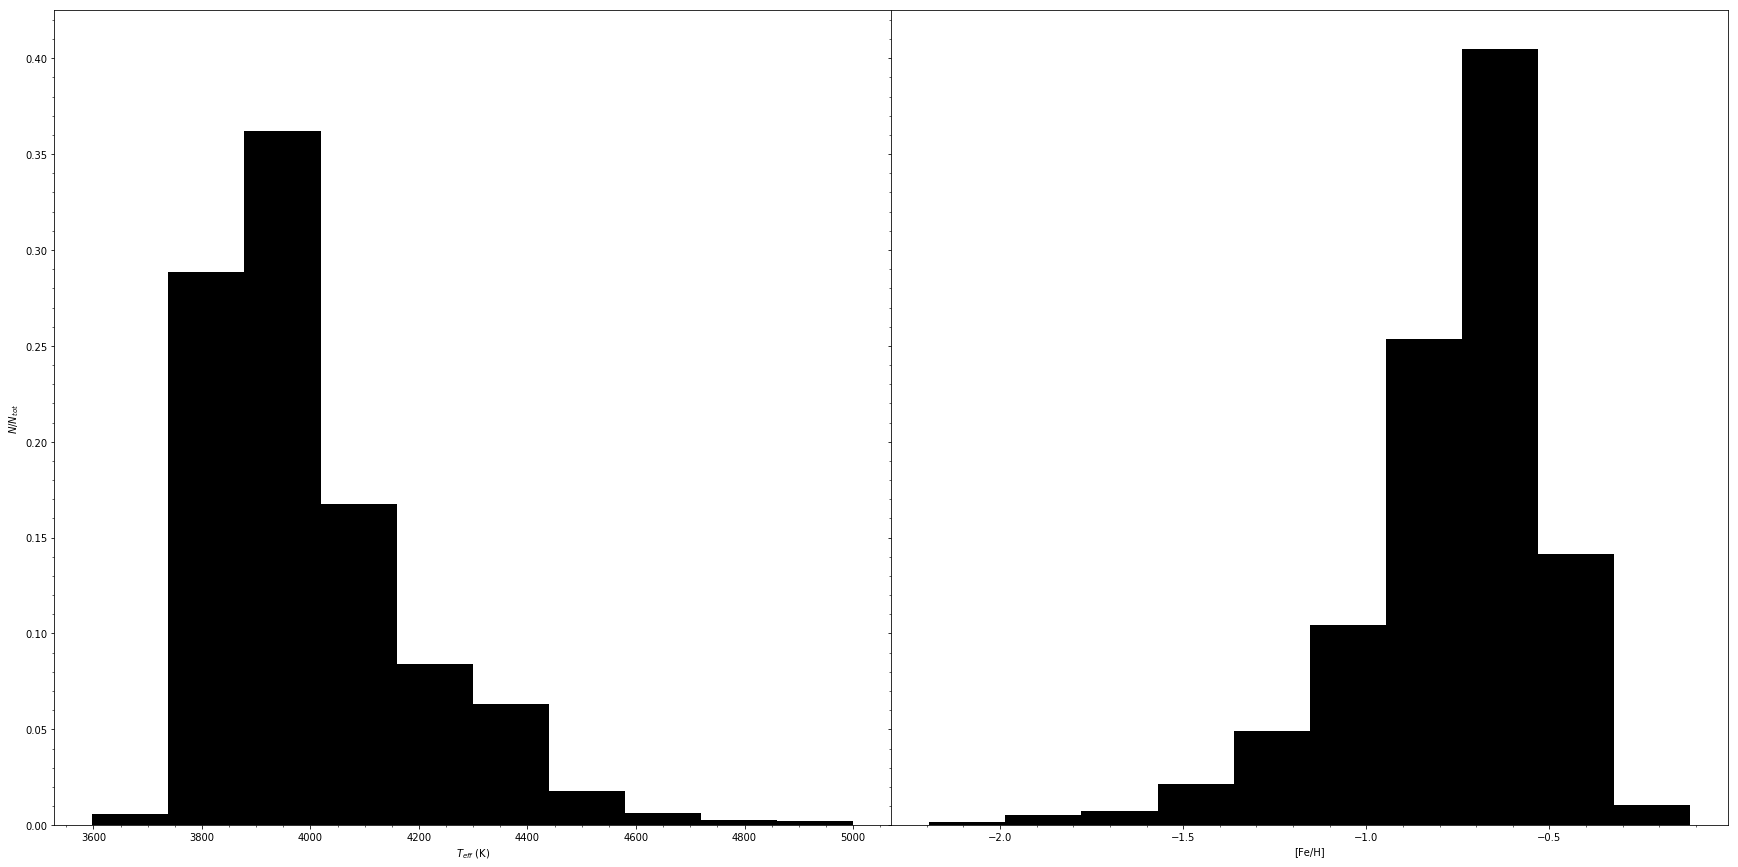

In [13]:
##############################################
### Temperature and Metallicity Histograms ###
##############################################

f, ax = plt.subplots(1,2,sharey=True,facecolor='w',figsize=(30,15))
teffweights = np.ones_like(r13['TEFF'])/float(len(r13['TEFF']))
fehweights = np.ones_like(r13['FE_H'])/float(len(r13['FE_H']))
ax[0].hist(r13['TEFF'],color='k',weights=teffweights)
ax[0].set_xlabel(r'$T_{eff}$ (K)')
ax[0].set_ylabel(r'$N/N_{tot}$')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].hist(r13['FE_H'],color='k',weights=fehweights)
ax[1].set_xlabel(r'[Fe/H]')
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('Teff_FeH_histogram.pdf',bbox_inches='tight')
plt.show()

In [14]:
len(r13)

2427

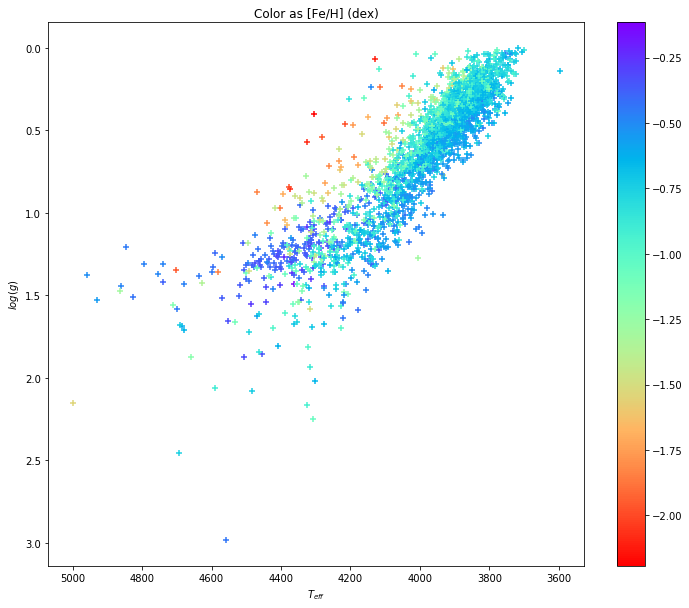

In [15]:
plt.figure(figsize=[12,10])
plt.scatter(r13['TEFF'],r13['LOGG'],marker='+',c=r13['FE_H'],cmap='rainbow_r')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'$log(g)$')
plt.title(r'Color as [Fe/H] (dex)')
plt.savefig('sHR_allstars.pdf',bbox_inches='tight')
plt.show()

In [16]:
min(r13['FE_H'])

-2.1930616

In [17]:
##########################################
### Calculate Gradients and intercepts ###
##########################################

import statsmodels.api as sm

### Circular galactic radius for LMC
radius = np.sqrt((LMCdisk_cart(r13['RA'],r13['DEC'])[0])**2+(LMCdisk_cart(r13['RA'],r13['DEC'])[1])**2)

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

elems_slope = []
elems_inter = []

for i in range(len(elems)-5):
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(radius[cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(r13[elems[i]][cln],pmodl).fit()
    elems_slope.append(model.params[1])
    elems_inter.append(model.params[0])
    
scelems_slope = []
scelems_inter = []

for i in range(len(elems)-5):
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(radius[cln]*0.59643876).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(r13[elems[i]][cln],pmodl).fit()
    scelems_slope.append(model.params[1])
    scelems_inter.append(model.params[0])
    
for j in range(len(elems)-5):
    print(elems[j]+' slope: '+str(elems_slope[j])+ ' inter: '+ str(elems_inter[j]))

M_H slope: -0.04960612679627079 inter: -0.5683580363447468
C_FE slope: -0.022616068659300985 inter: -0.27072367264603786
N_FE slope: -0.013758492973373606 inter: 0.1674920395911752
O_FE slope: 0.002502164284188434 inter: 0.023389718102673616
NA_FE slope: 0.004649956956659073 inter: -0.20038507021982682
MG_FE slope: 0.005485980429677274 inter: 0.09005288619067141
AL_FE slope: -0.012409590514919142 inter: -0.31128257928543196
SI_FE slope: 0.005595181068073198 inter: -0.016985922736462086
P_FE slope: 0.03243669133726645 inter: -0.03210373571221403
S_FE slope: 0.013385342656524366 inter: 0.146213936257344
K_FE slope: 0.013519063581569072 inter: -0.03832245013328531
CA_FE slope: -0.001759705502346297 inter: 0.10691402126784252
TI_FE slope: 0.02157226621387457 inter: -0.15559960189644356
TIII_FE slope: 0.05202945337257352 inter: -0.20250747717975123
V_FE slope: -0.010470097198442467 inter: -0.09026935722542746
CR_FE slope: -0.009233853243884337 inter: 0.05821469255176545
MN_FE slope: -0.0275

In [18]:
########################################
### Calculate Gradient Uncertainties ###
########################################

msm_devs = []
msb_devs = []
for i in tqdm_notebook(range(len(elems)-5)):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13[cln]
    clnrads = radius[cln]
    
    for j in tqdm_notebook(range(100)):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(clnrads[ind]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs[elems[i]],pmodl).fit()
        msslopes.append(model.params[1])
        msinters.append(model.params[0])
        
    msm_devs.append(mad(msslopes))
    msb_devs.append(mad(msinters))
    
###Scaled to scale length of 1.68 kpc
scale = 1.68 #kpc for LMC    

sc_msm_devs = []
sc_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),leave=False):
    
    sc_msslopes = []
    sc_msinters = []
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13[cln]
    clnrads = radius[cln]
    
    for j in tqdm_notebook(range(1000)):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(clnrads[ind]/scale).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs[elems[i]],pmodl).fit()
        sc_msslopes.append(model.params[1])
        sc_msinters.append(model.params[0])
        
    sc_msm_devs.append(mad(sc_msslopes))
    sc_msb_devs.append(mad(sc_msinters))

KeyboardInterrupt: 

In [19]:
######################
### Calculate Ages ###
######################

def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

x, y, stardist = LMCdisk_cart(r13['RA'],r13['DEC']) # dist2LMC(r13['RA'],r13['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(r13['K'],stardist)-r13['AK_TARG']
parage = parsec_age(np.log10(r13['TEFF']),corabsK,sal(r13['M_H'],metscorr),r13['LOGG'])
parage = np.squeeze(parage)

In [20]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

age_devs = []

for i in range(len(r13)):
    lgT = np.log10(r13['TEFF'][i])
    lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
    ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
    mhERR = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfeERR = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
    lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    age_devs.append(mad(ages))

In [21]:
################
### Age Bins ###
################

young = np.where(parage<=np.log10(0.5*10**9))
yless = np.where((parage>np.log10(0.5*10**9))&(parage<=np.log10(2.0*10**9)))
ymed = np.where((parage>np.log10(2.0*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))

bloop = np.where((clndr16['TEFF']>=4100)&(clndr16['H']<=13.0)&((clndr16['J']-clndr16['K'])<=0.95))

bloop_cut = []
for i in range(len(clndr16)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]
bloopage = np.asarray(parage)[bloop_cut]

bloop_young = np.where(bloopage<=np.log10(0.5*10**9))
bloop_yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9)))
bloop_ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9)))
bloop_omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9)))
bloop_old = np.where(bloopage>np.log10(10.5*10**9))

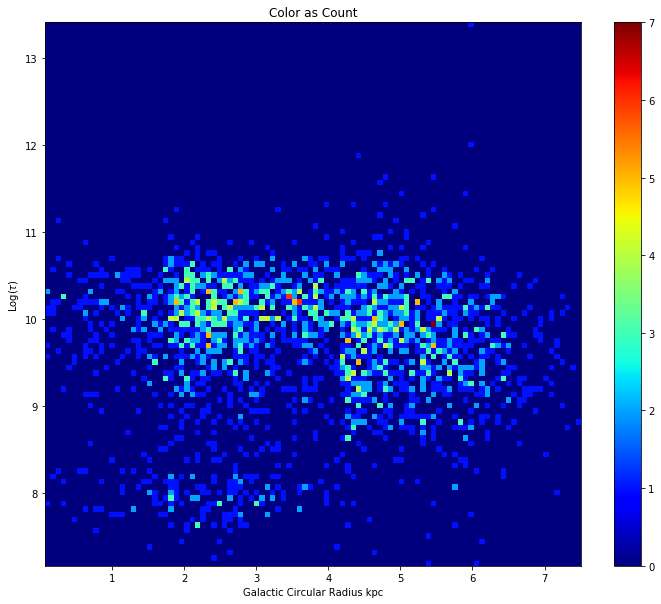

In [22]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[12,10])
density = binned_statistic_2d(np.sqrt(x**2+y**2),parage,
                              None,'count',bins=100)
plt.imshow(density.statistic.T, origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                 density.y_edge[0],density.y_edge[-1]],
           aspect='auto', interpolation='nearest',cmap='jet',label='_nolegend_')

plt.colorbar()
plt.title(r'Color as Count')
plt.xlabel(r'Galactic Circular Radius kpc')
plt.ylabel(r'Log($\tau$)')
plt.savefig('ageraddesnity.pdf',bbox_inches='tight')
plt.show()

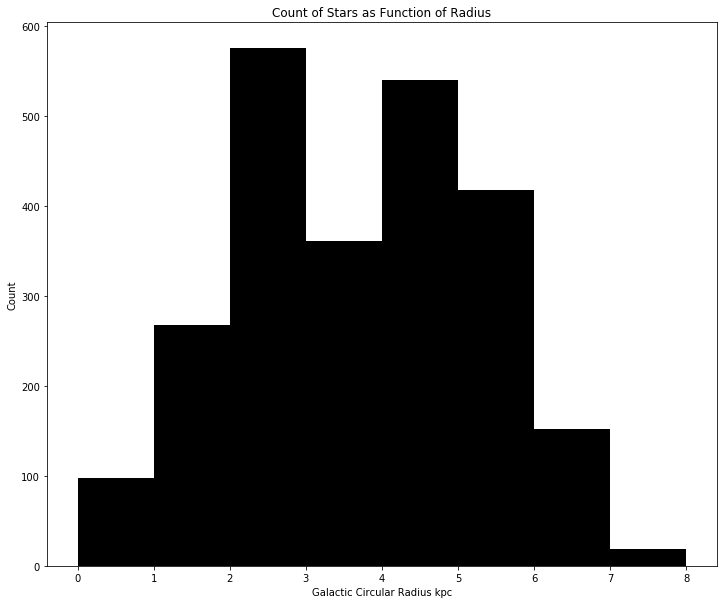

In [23]:
plt.figure(figsize=[12,10])
plt.hist(np.sqrt(x**2+y**2),bins=[0,1,2,3,4,5,6,7,8],color='k')
plt.xlabel(r'Galactic Circular Radius kpc')
plt.ylabel(r'Count')
plt.title(r'Count of Stars as Function of Radius')
plt.savefig('densityradius.pdf',bbox_inches='tight')
plt.show()

In [24]:
########################################
### Calculate Gradient Uncertainties ###
########################################

bloop_elems_slope = []
bloop_elems_inter = []

for i in range(len(elems)-5):
    cln = np.where((bloopr13[elems[i]]>-100)&(bloopr13['SNR']>=100)&
                   (kthbitset(bloopr13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(np.asarray(radius)[bloop_cut][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(bloopr13[elems[i]][cln],pmodl).fit()
    bloop_elems_slope.append(model.params[1])
    bloop_elems_inter.append(model.params[0])
    

bloop_msm_devs = []
bloop_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5)):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloopr13[elems[i]]>-100)&(bloopr13['SNR']>=100)&
                   (kthbitset(bloopr13['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloopr13[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in tqdm_notebook(range(500),leave=False):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(clnrads[ind]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs[elems[i]],pmodl).fit()
        msslopes.append(model.params[1])
        msinters.append(model.params[0])
        
    bloop_msm_devs.append(mad(msslopes))
    bloop_msb_devs.append(mad(msinters))

In [25]:
###################################################
### Age Bins Calculate Gradients and intercepts ###
###################################################

### young ###
bloop_young_elems_slope = []
bloop_young_elems_inter = []

bloop_r13young = bloopr13[bloop_young]
bloop_radiusyoung = np.asarray(radius)[bloop_cut][bloop_young]

for i in tqdm_notebook(range(len(elems)-5),desc='young'):
    cln = np.where((bloop_r13young[elems[i]]>-100)&(bloop_r13young['SNR']>=100)&
                   (kthbitset(bloop_r13young['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(bloop_radiusyoung[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(bloop_r13young[elems[i]][cln],pmodl).fit()
        bloop_young_elems_slope.append(model.params[1])
        bloop_young_elems_inter.append(model.params[0]) 
    
    except:
        bloop_young_elems_slope.append(-9999.0)
        blooop_young_elems_inter.append(-9999.0)
        
### yless ###
bloop_yless_elems_slope = []
bloop_yless_elems_inter = []

bloop_r13yless = bloopr13[bloop_yless]
bloop_radiusyless = np.asarray(radius)[bloop_cut][bloop_yless]

for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    cln = np.where((bloop_r13yless[elems[i]]>-100)&(bloop_r13yless['SNR']>=100)&
                   (kthbitset(bloop_r13yless['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(bloop_radiusyless[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(bloop_r13yless[elems[i]][cln],pmodl).fit()
        bloop_yless_elems_slope.append(model.params[1])
        bloop_yless_elems_inter.append(model.params[0]) 
    
    except:
        bloop_yless_elems_slope.append(-9999.0)
        bloop_yless_elems_inter.append(-9999.0)
    
### ymed ###
bloop_ymed_elems_slope = []
bloop_ymed_elems_inter = []

bloop_r13ymed = bloopr13[bloop_ymed]
bloop_radiusymed = np.asarray(radius)[bloop_cut][bloop_ymed]

for i in tqdm_notebook(range(len(elems)-5),desc='ymed'):
    cln = np.where((bloop_r13ymed[elems[i]]>-100)&(bloop_r13ymed['SNR']>=100)&
                   (kthbitset(bloop_r13ymed['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(bloop_radiusymed[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(bloop_r13ymed[elems[i]][cln],pmodl).fit()
        bloop_ymed_elems_slope.append(model.params[1])
        bloop_ymed_elems_inter.append(model.params[0]) 
    
    except:
        bloop_ymed_elems_slope.append(-9999.0)
        bloop_ymed_elems_inter.append(-9999.0)
    
### omed ###
bloop_omed_elems_slope = []
bloop_omed_elems_inter = []

bloop_r13omed = bloopr13[bloop_omed]
bloop_radiusomed = np.asarray(radius)[bloop_cut][bloop_omed]

for i in tqdm_notebook(range(len(elems)-5),desc='omed'):
    cln = np.where((bloop_r13omed[elems[i]]>-100)&(bloop_r13omed['SNR']>=100)&
                   (kthbitset(bloop_r13omed['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(bloop_radiusomed[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(bloop_r13omed[elems[i]][cln],pmodl).fit()
        bloop_omed_elems_slope.append(model.params[1])
        bloop_omed_elems_inter.append(model.params[0]) 
    
    except:
        bloop_omed_elems_slope.append(-9999.0)
        bloop_omed_elems_inter.append(-9999.0)
    
### old ###
bloop_old_elems_slope = []
bloop_old_elems_inter = []

bloop_r13old = bloopr13[bloop_old]
bloop_radiusold = np.asarray(radius)[bloop_cut][bloop_old]

for i in tqdm_notebook(range(len(elems)-5),desc='old'):
    cln = np.where((bloop_r13old[elems[i]]>-100)&(bloop_r13old['SNR']>=100)&
                   (kthbitset(bloop_r13old['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(bloop_radiusold[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(bloop_r13old[elems[i]][cln],pmodl).fit()
        bloop_old_elems_slope.append(model.params[1])
        bloop_old_elems_inter.append(model.params[0]) 
    
    except:
        bloop_old_elems_slope.append(-9999.0)
        bloop_old_elems_inter.append(-9999.0)

In [26]:
print(bloop_young_elems_slope)

[-0.04577628028003289, -0.010560883756646504, -0.009780754694629894, 0.023100512003071828, 0.016811690389195073, 0.027084809399612497, 0.008260771979084449, 0.01915119792801879, 0.04044177060544479, 0.040895981873233234, 0.025579465894447737, 0.009825957736620447, 0.01936554428579882, 0.07220943303594436, 0.04961655423564677, -0.02213983843135895, -0.014214553502341434, -0.04632976780987124, 0.026083384854890156, 0.01634637418846343, 0.01756177171982628]


In [27]:
# ##########################################################
# ### Scaled Age Bins Calculate Gradients and intercepts ###
# ##########################################################
# scale = 1.68 #kpc for the LMC

# ### young ###
# sc_young_elems_slope = []
# sc_young_elems_inter = []

# r13young = r13[young]
# radiusyoung = radius[young]

# for i in range(len(elems)-5):
#     cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&
#                    (kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
#     try:
#         pmodl = np.array(radiusyoung[cln]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(r13young[elems[i]][cln],pmodl).fit()
#         sc_young_elems_slope.append(model.params[1])
#         sc_young_elems_inter.append(model.params[0]) 
    
#     except:
#         sc_young_elems_slope.append(-9999.0)
#         sc_young_elems_inter.append(-9999.0)
        
# ### yless ###
# sc_yless_elems_slope = []
# sc_yless_elems_inter = []

# r13yless = r13[yless]
# radiusyless = radius[yless]

# for i in range(len(elems)-5):
#     cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100)&
#                    (kthbitset(r13yless['ASPCAPFLAG'],23)=='False'))
#     try:
#         pmodl = np.array(radiusyless[cln]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(r13yless[elems[i]][cln],pmodl).fit()
#         sc_yless_elems_slope.append(model.params[1])
#         sc_yless_elems_inter.append(model.params[0]) 
    
#     except:
#         sc_yless_elems_slope.append(-9999.0)
#         sc_yless_elems_inter.append(-9999.0)


# ### ymed ###
# sc_ymed_elems_slope = []
# sc_ymed_elems_inter = []

# r13ymed = r13[ymed]
# radiusymed = radius[ymed]

# for i in range(len(elems)-5):
#     cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&
#                    (kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
#     try:
#         pmodl = np.array(radiusymed[cln]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(r13ymed[elems[i]][cln],pmodl).fit()
#         sc_ymed_elems_slope.append(model.params[1])
#         sc_ymed_elems_inter.append(model.params[0]) 
    
#     except:
#         sc_ymed_elems_slope.append(-9999.0)
#         sc_ymed_elems_inter.append(-9999.0)
    
# ### omed ###
# sc_omed_elems_slope = []
# sc_omed_elems_inter = []

# r13omed = r13[omed]
# radiusomed = radius[omed]

# for i in range(len(elems)-5):
#     cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&
#                    (kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
#     try:
#         pmodl = np.array(radiusomed[cln]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(r13omed[elems[i]][cln],pmodl).fit()
#         sc_omed_elems_slope.append(model.params[1])
#         sc_omed_elems_inter.append(model.params[0]) 
    
#     except:
#         sc_omed_elems_slope.append(-9999.0)
#         sc_omed_elems_inter.append(-9999.0)
    
# ### old ###
# sc_old_elems_slope = []
# sc_old_elems_inter = []

# r13old = r13[old]
# radiusold = radius[old]

# for i in range(len(elems)-5):
#     cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&
#                    (kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
#     try:
#         pmodl = np.array(radiusold[cln]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(r13old[elems[i]][cln],pmodl).fit()
#         sc_old_elems_slope.append(model.params[1])
#         sc_old_elems_inter.append(model.params[0]) 
    
#     except:
#         sc_old_elems_slope.append(-9999.0)
#         sc_old_elems_inter.append(-9999.0)

In [28]:
# young_msm_devs = []
# young_msb_devs = []

# msslopes = []
# msinters = []
    
# cln = np.where((r13young['NA_FE']>-100)&(r13young['SNR']>=100)&(kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
# clnstrs = r13young[cln]
# clnrads = radius[cln]
    
# for j in range(100):
        
#     ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#     indstrs = clnstrs[ind]
        
#     try:
#         pmodl = np.array(clnrads[ind]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(indstrs['NA_FE'],pmodl).fit()
#         msslopes.append(model.params[1])
#         msinters.append(model.params[0])
        
#     except:
#         msslopes.append(-9999.0)
#         msinters.append(-9999.0)
#         print('except')
            
# #     print(msslopes)
# #     print('---')
# # young_msm_devs.append(mad(msslopes))
# # young_msb_devs.append(mad(msinters))


In [29]:
# indstrs['NA_FE']

In [30]:
###########################
### Age Bin Uncertainty ###
###########################

### leq 0.5 ###
bloop_young_msm_devs = []
bloop_young_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='young'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloop_r13young[elems[i]]>-100)&(bloop_r13young['SNR']>=100)&
                   (kthbitset(bloop_r13young['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloop_r13young[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    bloop_young_msm_devs.append(mad(msslopes))
    bloop_young_msb_devs.append(mad(msinters))

print('young uncertainty done')

### 0.5 < t \leq 2.0 ###
bloop_yless_msm_devs = []
bloop_yless_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloop_r13yless[elems[i]]>-100)&(bloop_r13yless['SNR']>=100)&
                   (kthbitset(bloop_r13yless['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloop_r13yless[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    bloop_yless_msm_devs.append(mad(msslopes))
    bloop_yless_msb_devs.append(mad(msinters))

print('young uncertainty done')
    
### 2.0 < t \leq 7.0 ###
bloop_ymed_msm_devs = []
bloop_ymed_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='ymed'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloop_r13ymed[elems[i]]>-100)&(bloop_r13ymed['SNR']>=100)&
                   (kthbitset(bloop_r13ymed['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloop_r13ymed[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    bloop_ymed_msm_devs.append(mad(msslopes))
    bloop_ymed_msb_devs.append(mad(msinters))  
    
print('ymed uncertainty done')    
    
### 7.0 < t \leq 10.5 ###
bloop_omed_msm_devs = []
bloop_omed_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='omed'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloop_r13omed[elems[i]]>-100)&(bloop_r13omed['SNR']>=100)&
                   (kthbitset(bloop_r13omed['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloop_r13omed[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    bloop_omed_msm_devs.append(mad(msslopes))
    bloop_omed_msb_devs.append(mad(msinters))
    
print('omed uncertainty done')    
    
### 10.5 < t ###
bloop_old_msm_devs = []
bloop_old_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((bloop_r13old[elems[i]]>-100)&(bloop_r13old['SNR']>=100)&
                   (kthbitset(bloop_r13old['ASPCAPFLAG'],23)=='False'))
    clnstrs = bloop_r13old[cln]
    clnrads = np.asarray(radius)[bloop_cut][cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    bloop_old_msm_devs.append(mad(msslopes))
    bloop_old_msb_devs.append(mad(msinters))

print('old uncertainty done')

young uncertainty done


young uncertainty done


ymed uncertainty done


omed uncertainty done


old uncertainty done


In [31]:
# ##################################
# ### Scaled Age Bin Uncertainty ###
# ##################################

# scale = 1.68 #kpc for the LMC

# ### leq 3.5 ###
# sc_young_msm_devs = []
# sc_young_msb_devs = []
# for i in range(len(elems)-5):
    
#     msslopes = []
#     msinters = []
    
#     cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&
#                    (kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
#     clnstrs = r13young[cln]
#     clnrads = radius[cln]/scale
    
#     for j in range(100):
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         try:
#             pmodl = np.array(clnrads[ind]).T
#             pmodl = sm.add_constant(pmodl)
#             model = sm.RLM(indstrs[elems[i]],pmodl).fit()
#             msslopes.append(model.params[1])
#             msinters.append(model.params[0])
        
#         except:
#             msslopes.append(-9999.0)
#             msinters.append(-9999.0)
            
#     sc_young_msm_devs.append(mad(msslopes))
#     sc_young_msb_devs.append(mad(msinters))

# print('scale young uncertainty done')
    
# ### 3.5 < t \leq 7.0 ###
# sc_ymed_msm_devs = []
# sc_ymed_msb_devs = []
# for i in range(len(elems)-5):
    
#     msslopes = []
#     msinters = []
    
#     cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&
#                    (kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
#     clnstrs = r13ymed[cln]
#     clnrads = radius[cln]/scale
    
#     for j in range(100):
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         try:
#             pmodl = np.array(clnrads[ind]).T
#             pmodl = sm.add_constant(pmodl)
#             model = sm.RLM(indstrs[elems[i]],pmodl).fit()
#             msslopes.append(model.params[1])
#             msinters.append(model.params[0])
        
#         except:
#             msslopes.append(-9999.0)
#             msinters.append(-9999.0)
            
#     sc_ymed_msm_devs.append(mad(msslopes))
#     sc_ymed_msb_devs.append(mad(msinters))  
    
# print('scale ymed uncertainty done')    
    
# ### 7.0 < t \leq 10.5 ###
# sc_omed_msm_devs = []
# sc_omed_msb_devs = []
# for i in range(len(elems)-5):
    
#     msslopes = []
#     msinters = []
    
#     cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&
#                    (kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
#     clnstrs = r13omed[cln]
#     clnrads = radius[cln]/scale
    
#     for j in range(100):
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         try:
#             pmodl = np.array(clnrads[ind]).T
#             pmodl = sm.add_constant(pmodl)
#             model = sm.RLM(indstrs[elems[i]],pmodl).fit()
#             msslopes.append(model.params[1])
#             msinters.append(model.params[0])
        
#         except:
#             msslopes.append(-9999.0)
#             msinters.append(-9999.0)
            
#     sc_omed_msm_devs.append(mad(msslopes))
#     sc_omed_msb_devs.append(mad(msinters))
    
# print('scale omed uncertainty done')    
    
# ### 10.5 < t ###
# sc_old_msm_devs = []
# sc_old_msb_devs = []
# for i in range(len(elems)-5):
    
#     msslopes = []
#     msinters = []
    
#     cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&
#                    (kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
#     clnstrs = r13old[cln]
#     clnrads = radius[cln]/scale
    
#     for j in range(100):
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         try:
#             pmodl = np.array(clnrads[ind]).T
#             pmodl = sm.add_constant(pmodl)
#             model = sm.RLM(indstrs[elems[i]],pmodl).fit()
#             msslopes.append(model.params[1])
#             msinters.append(model.params[0])
        
#         except:
#             msslopes.append(-9999.0)
#             msinters.append(-9999.0)
            
#     sc_old_msm_devs.append(mad(msslopes))
#     sc_old_msb_devs.append(mad(msinters))

# print('scale old uncertainty done')

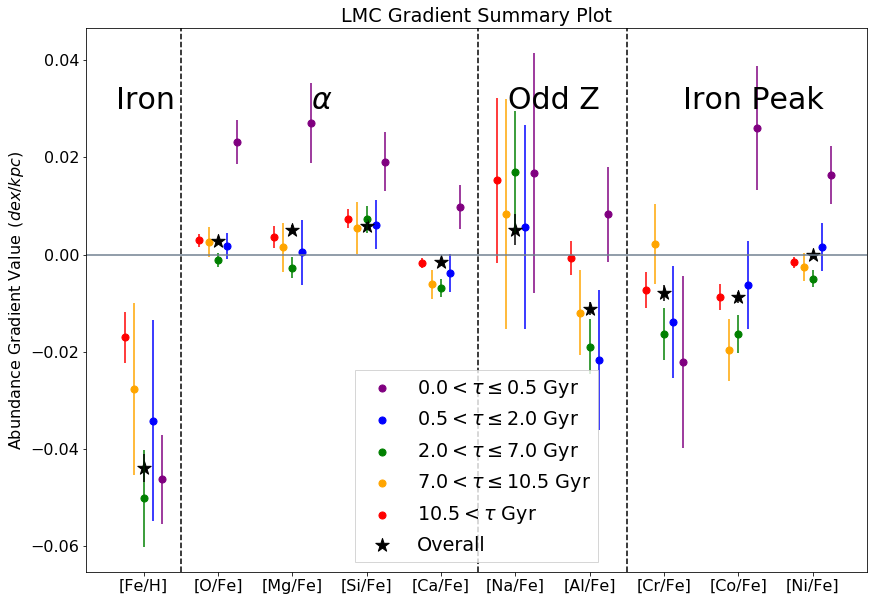

In [33]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]


# [np.squeeze(np.where(np.asarray(elems)=='O_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='AL_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='SI_FE')),np.squeeze(np.where(np.asarray(elems)=='CA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='CR_FE')),np.squeeze(np.where(np.asarray(elems)=='FE_H')),
#          np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(bloop_young_elems_slope[i])
    good_yless.append(bloop_yless_elems_slope[i])
    good_ymed.append(bloop_ymed_elems_slope[i])
    good_omed.append(bloop_omed_elems_slope[i])
    good_old.append(bloop_old_elems_slope[i])
    good_over.append(bloop_elems_slope[i])
    
    err_young.append(bloop_young_msm_devs[i])
    err_yless.append(bloop_yless_msm_devs[i])
    err_ymed.append(bloop_ymed_msm_devs[i])
    err_omed.append(bloop_omed_msm_devs[i])
    err_old.append(bloop_old_msm_devs[i])
    err_over.append(msm_devs[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[14,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.03,'Iron',fontsize=30)
plt.text(2.25,0.03,'$\\alpha$',fontsize=30)
plt.text(4.9,0.03,'Odd Z',fontsize=30)
plt.text(7.25,0.03,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary Plot')

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
plt.savefig('grad_summary_errs_plot.pdf',bbox_inches='tight')
plt.show()

In [34]:
plt.scatter(radius[young][young_cln],r13young[elems[i]][young_cln],marker='+',c='blue')
plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0)

NameError: name 'young_cln' is not defined

In [35]:
####

# young = np.where(parage<=np.log10(0.5*10**9))
# yless = np.where((parage>np.log10(0.5*10**9))&(parage<=np.log10(2.0*10**9)))
# ymed = np.where((parage>np.log10(2.0*10**9))&(parage<=np.log10(7*10**9)))
# omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
# old = np.where(parage>np.log10(10.5*10**9))



In [36]:
len(np.squeeze(bloop_old))

825

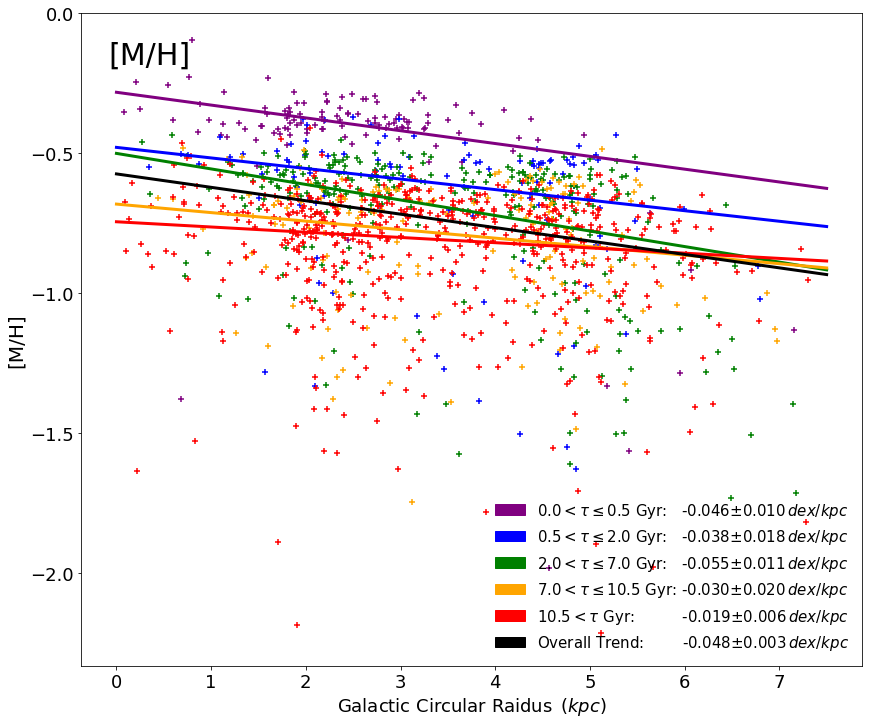

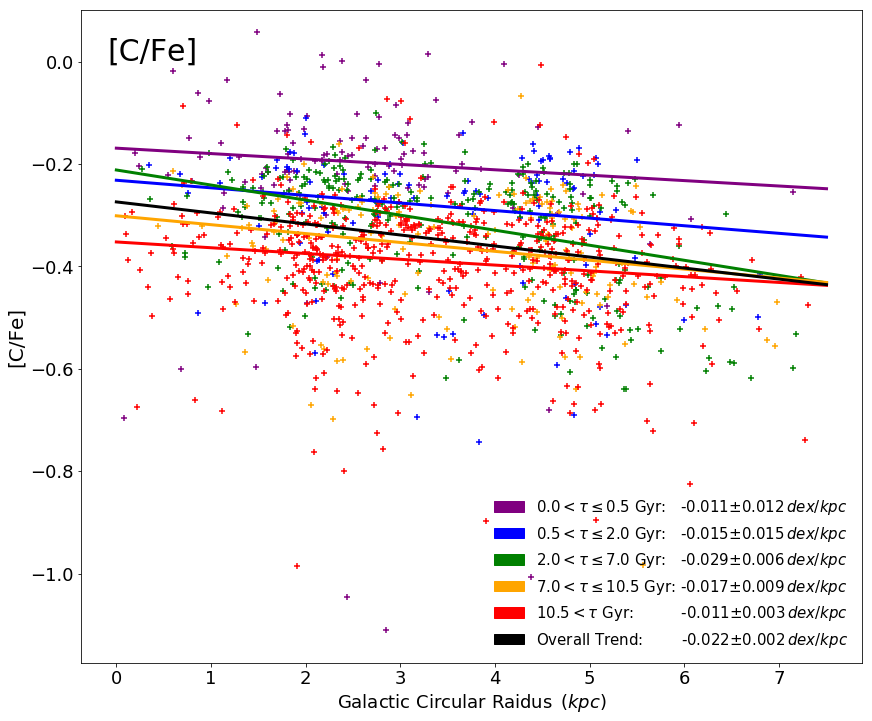

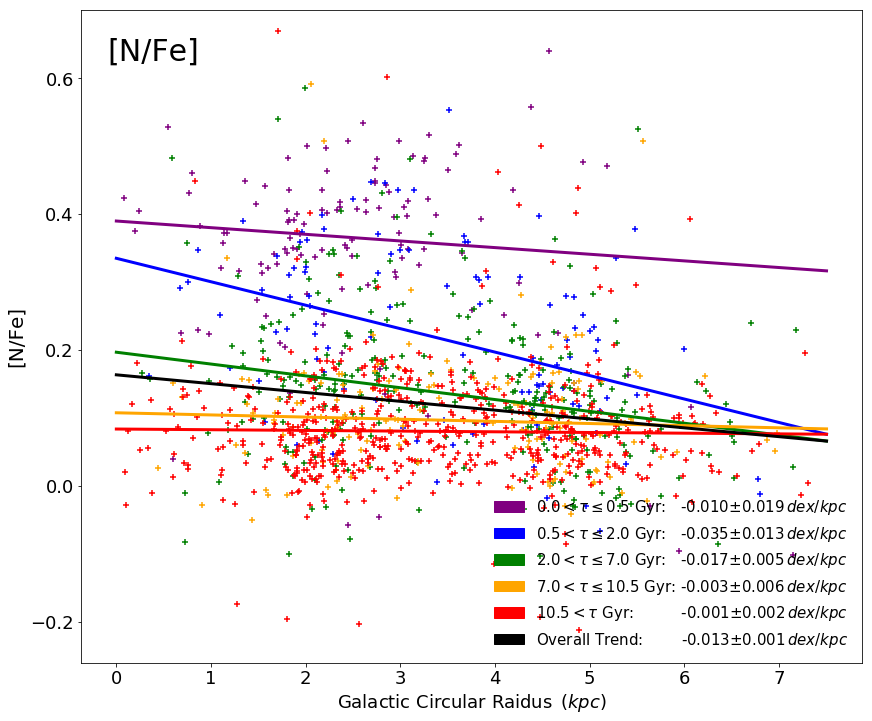

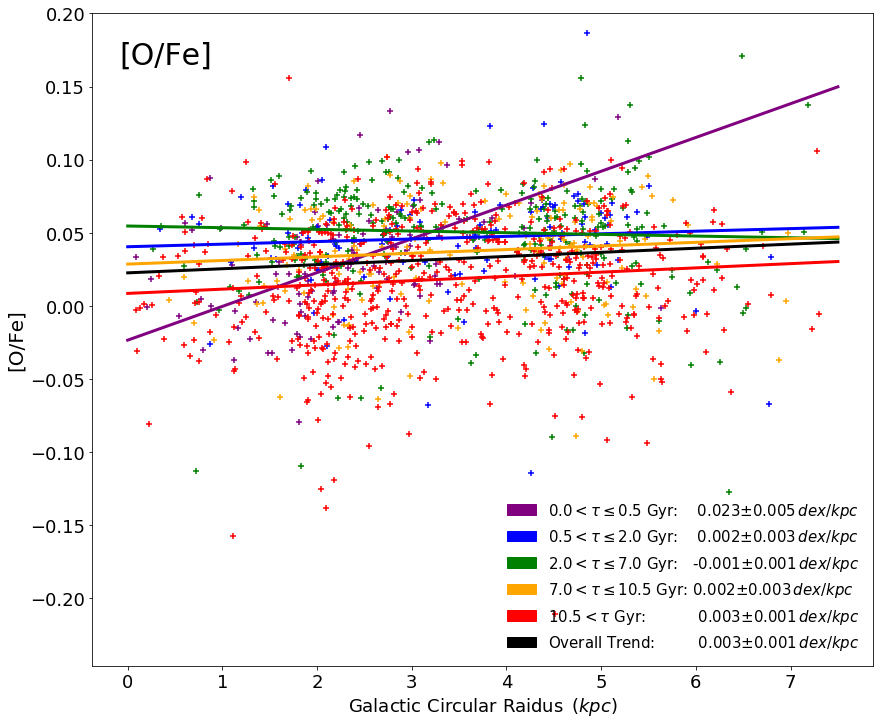

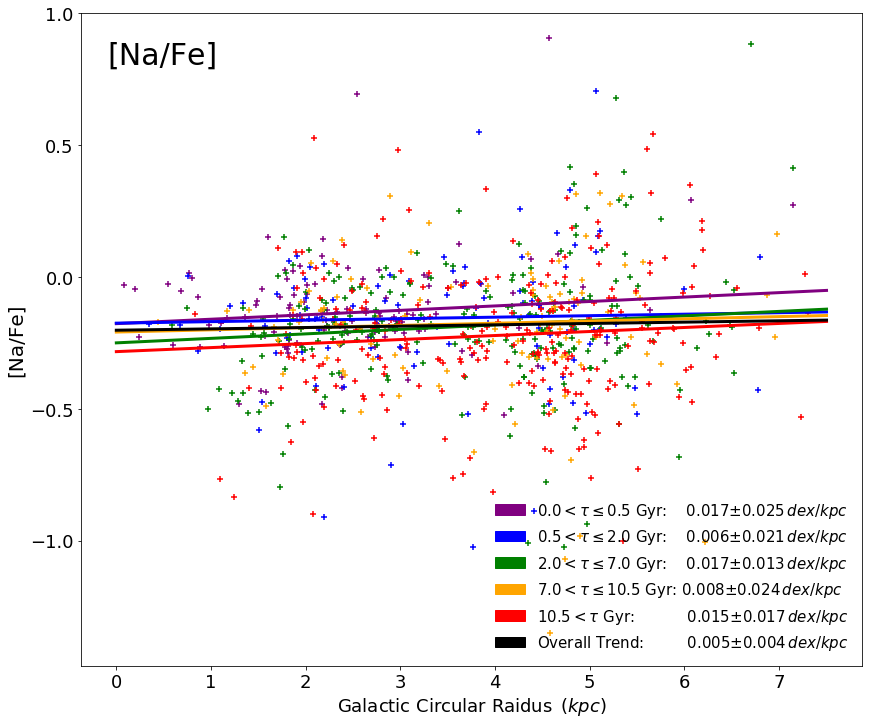

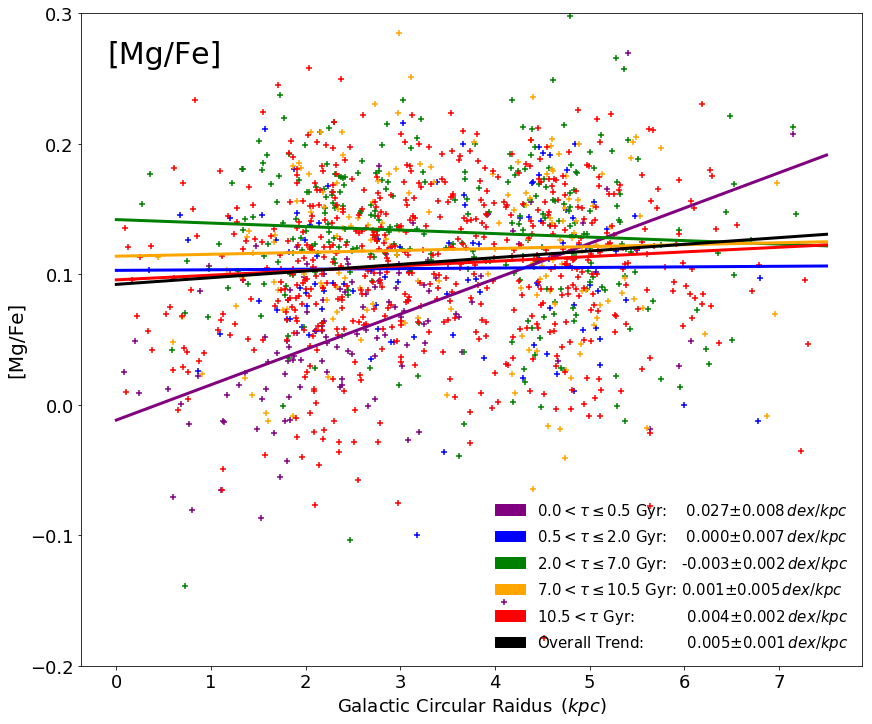

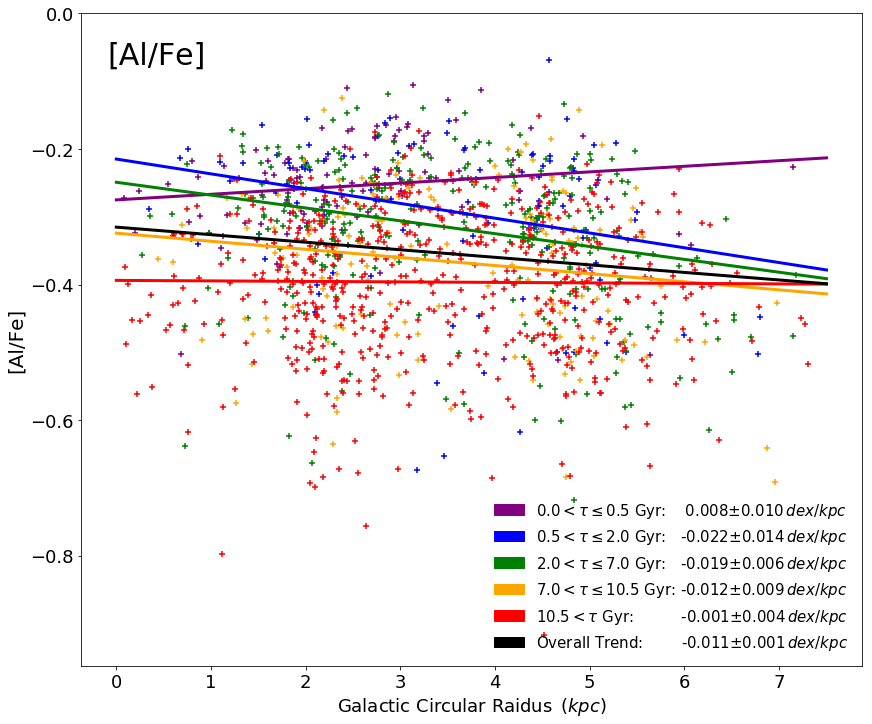

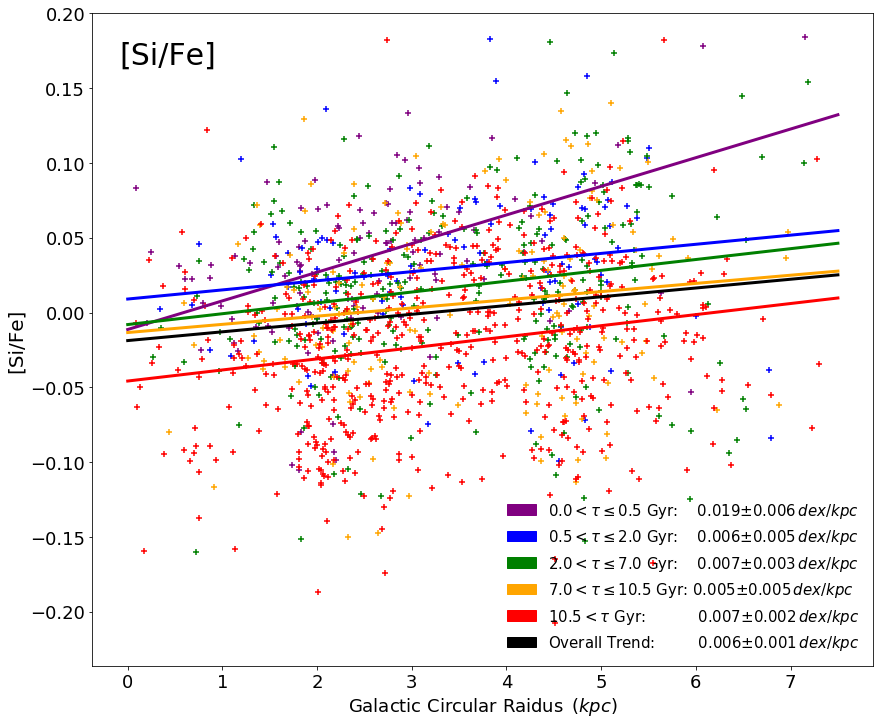

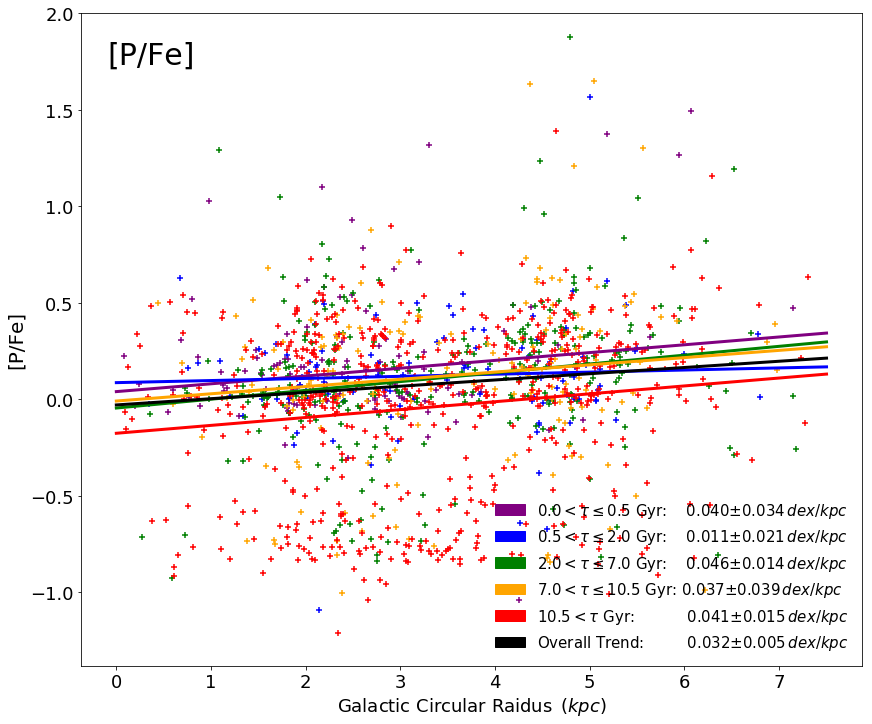

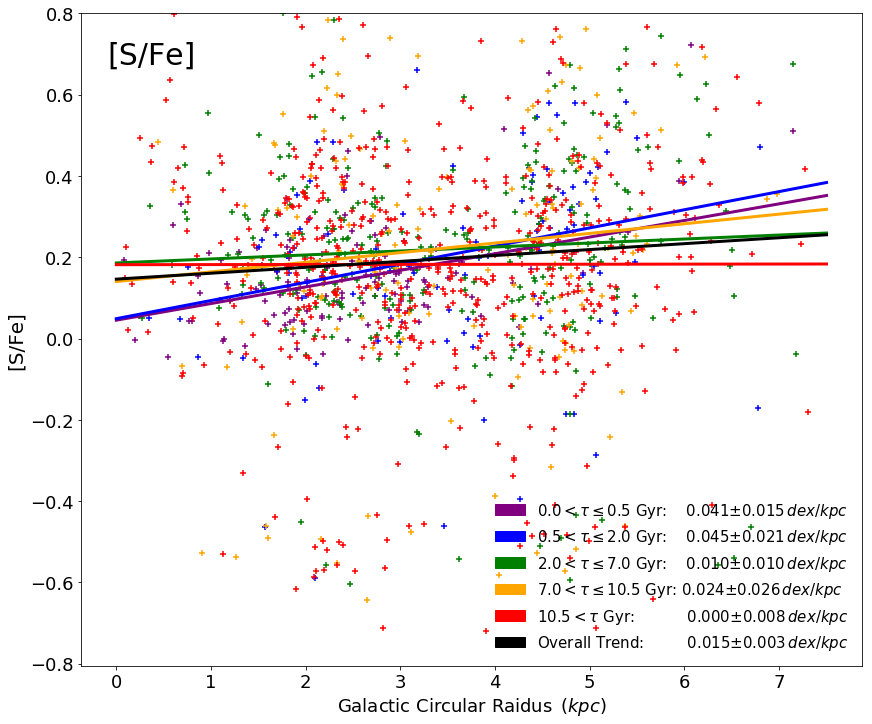

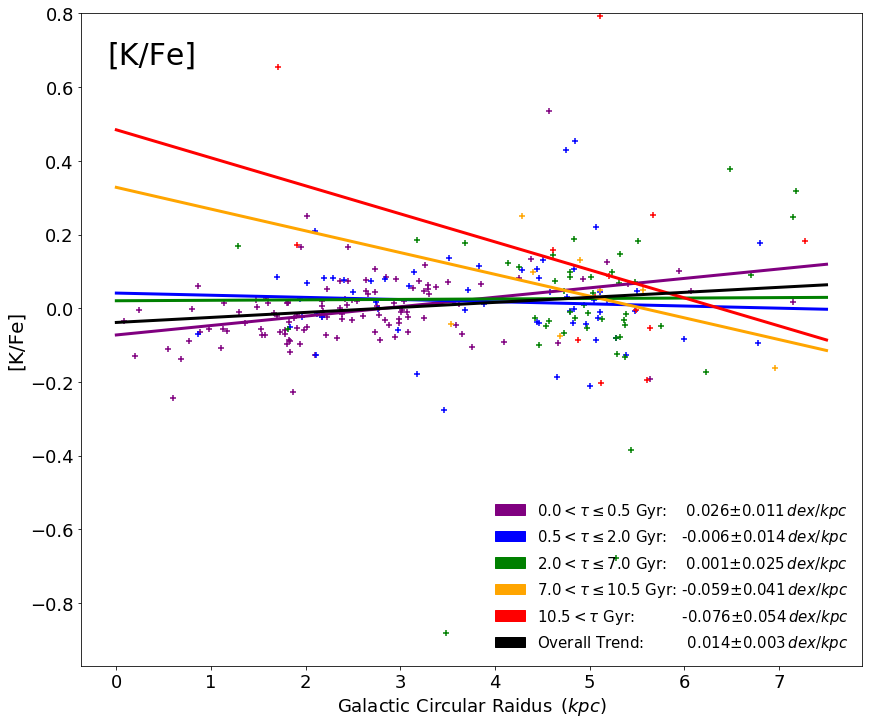

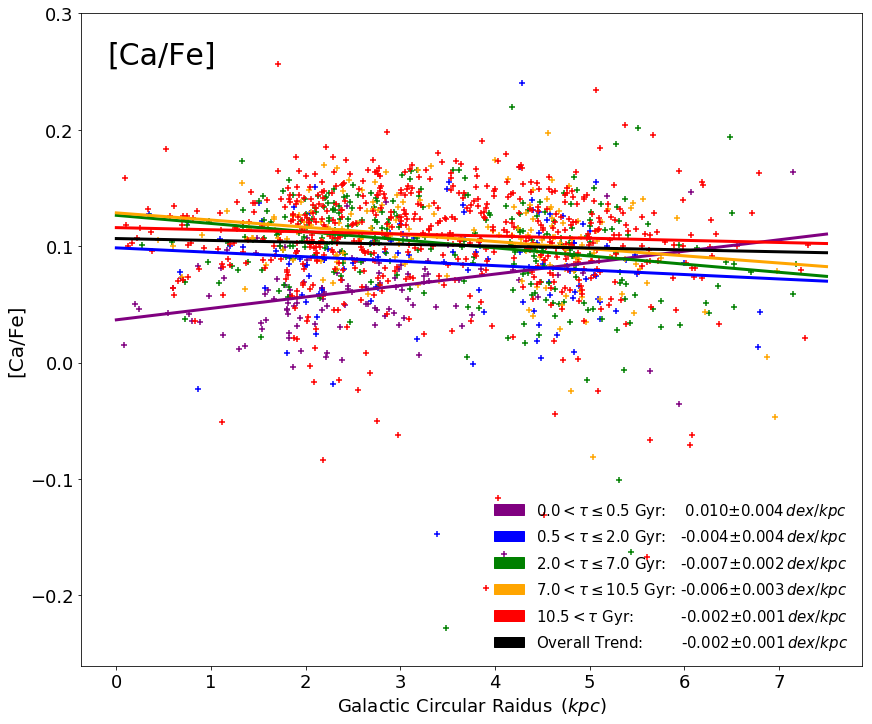

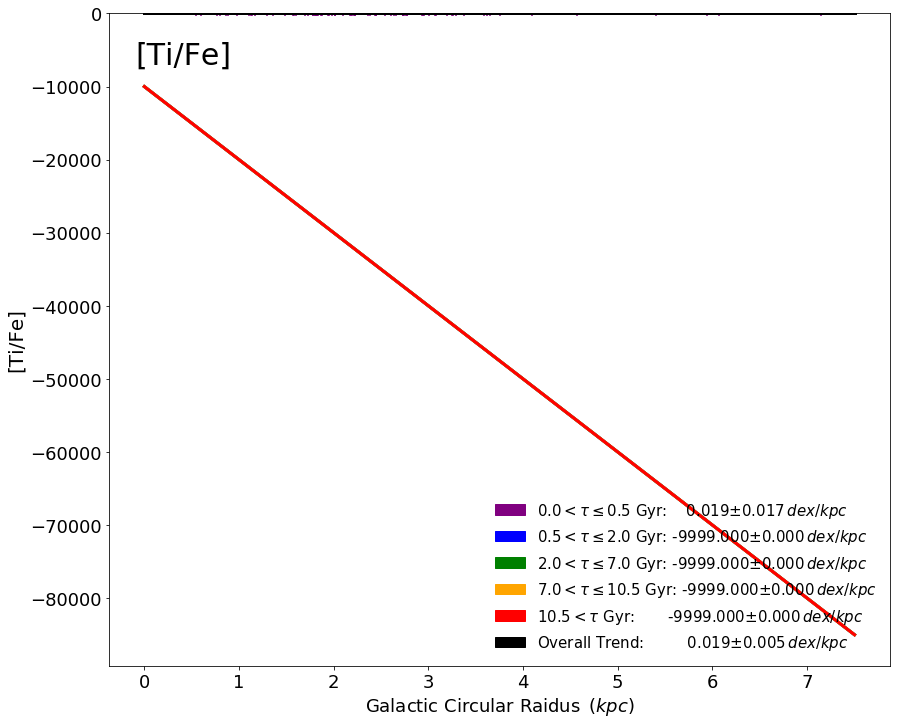

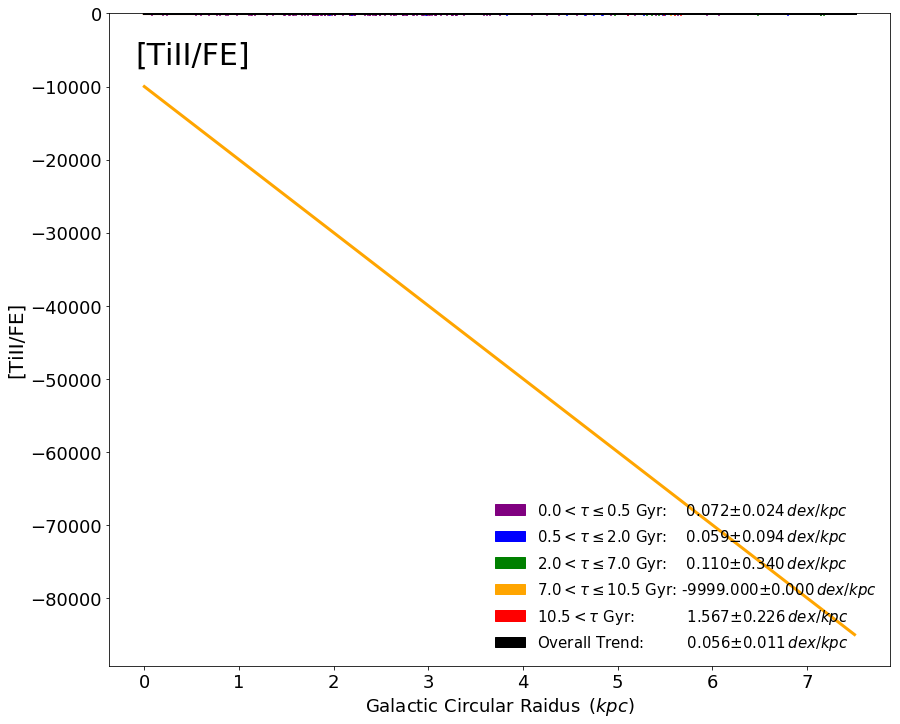

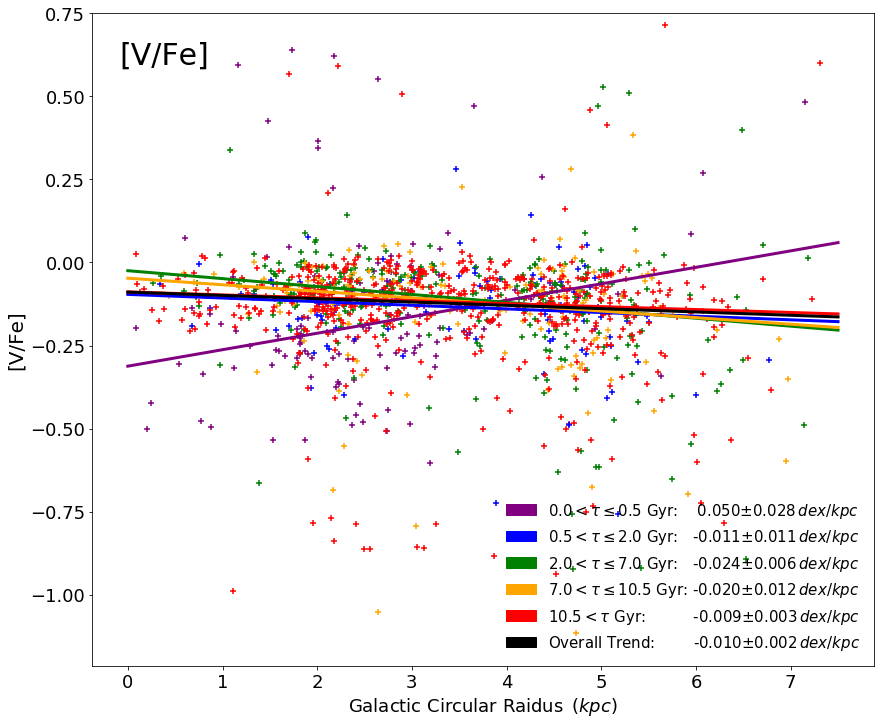

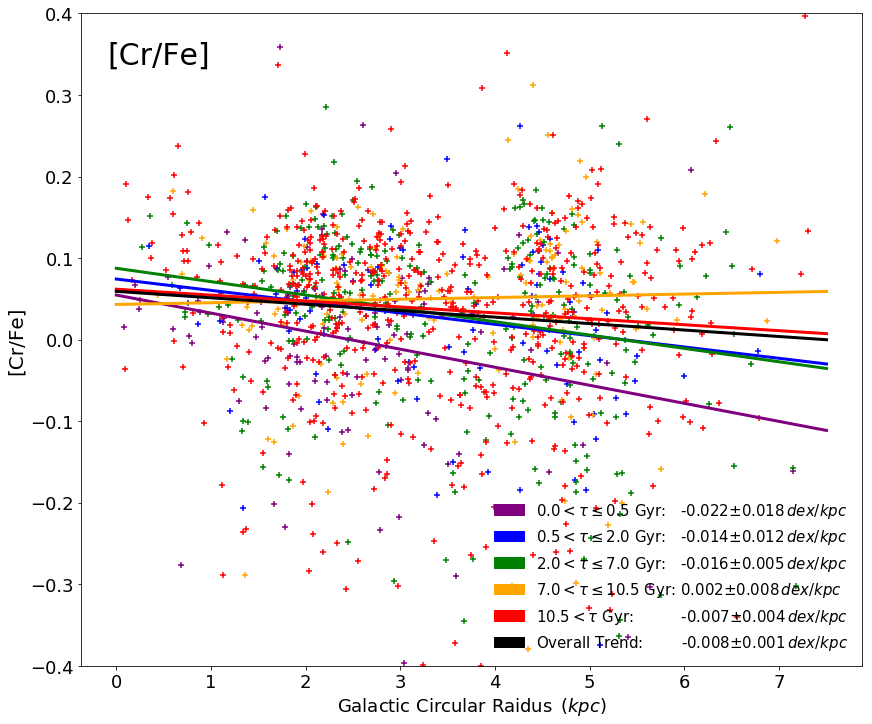

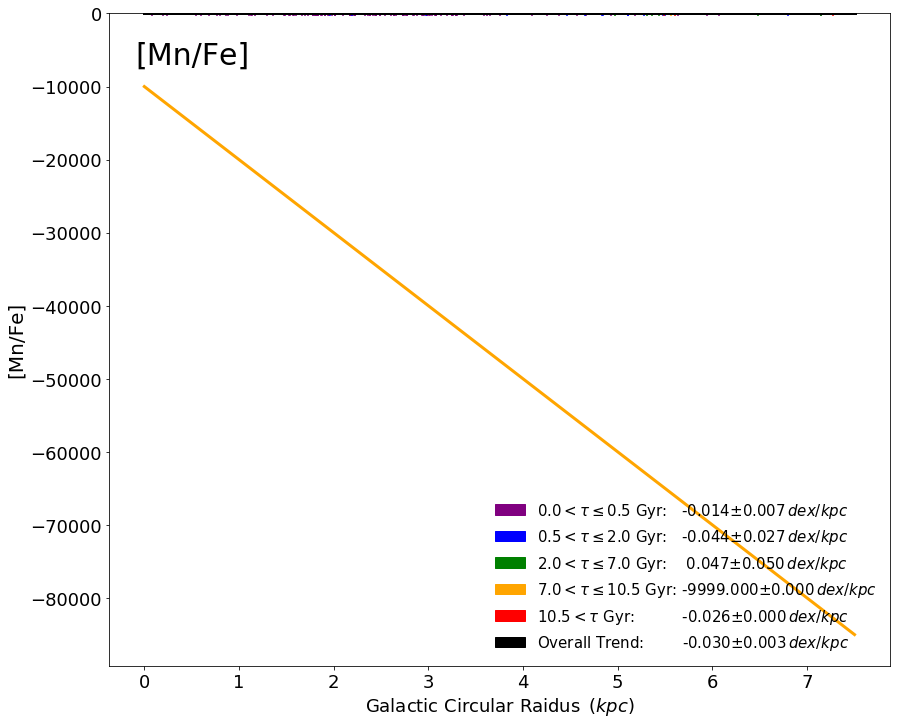

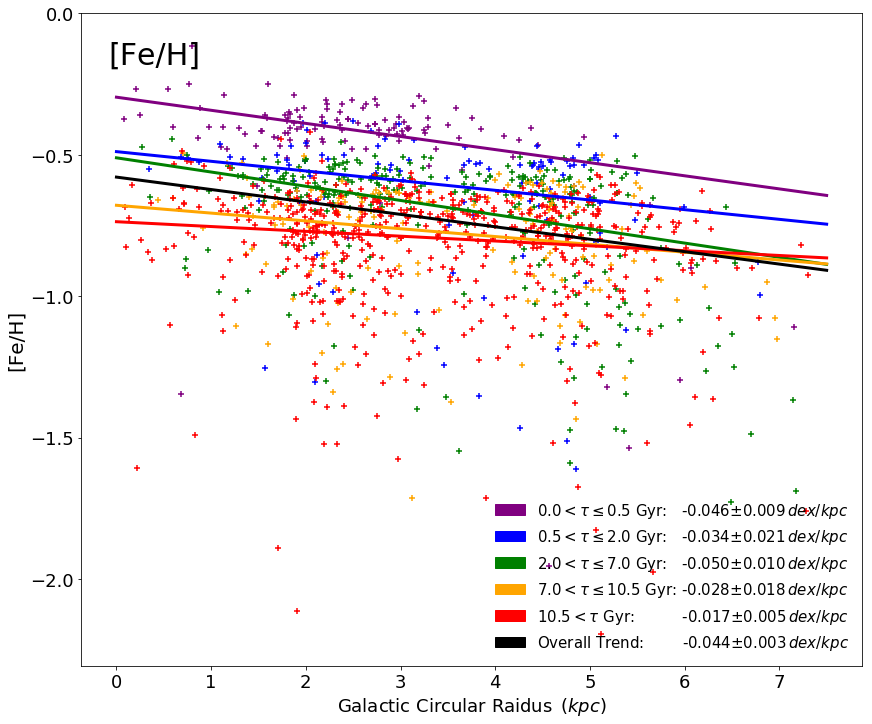

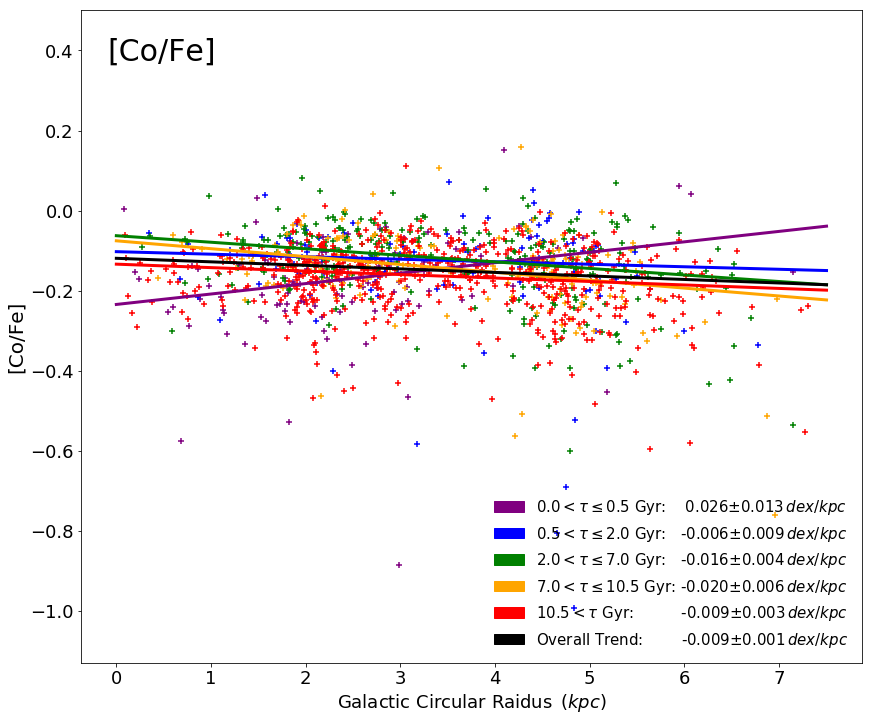

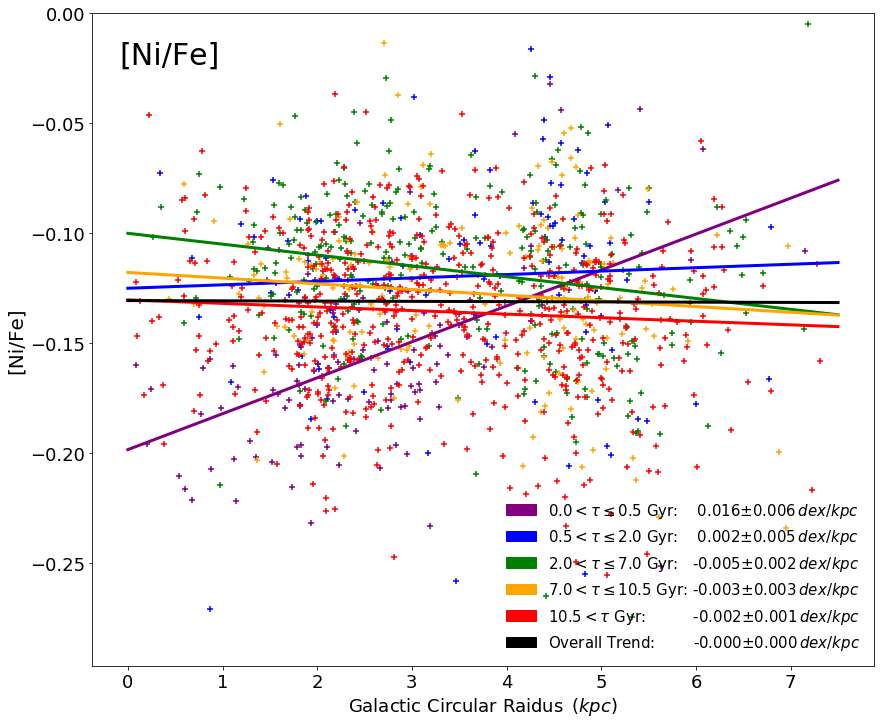

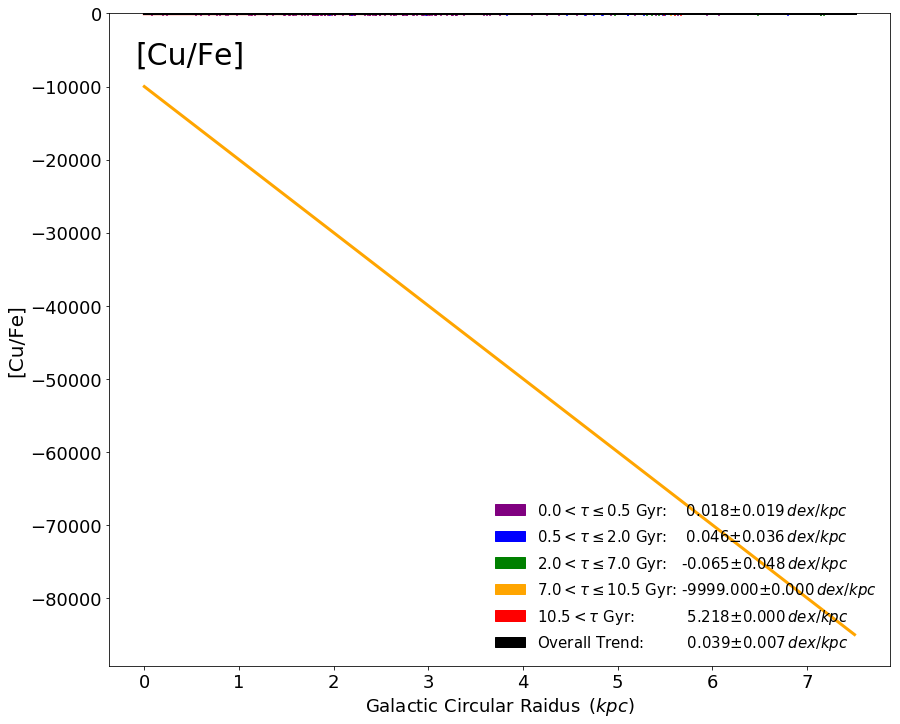

In [46]:
radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = bloopage[bloop_young]
yless_parage = bloopage[bloop_yless]
ymed_parage = bloopage[bloop_ymed]
omed_parage = bloopage[bloop_omed]
old_parage = bloopage[bloop_old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return bloop_young_elems_slope[i]*x+bloop_young_elems_inter[i]
    def ylesstrendline(x):
        return bloop_yless_elems_slope[i]*x+bloop_yless_elems_inter[i]
    def ymedtrendline(x):
        return bloop_ymed_elems_slope[i]*x+bloop_ymed_elems_inter[i]
    def omedtrendline(x):
        return bloop_omed_elems_slope[i]*x+bloop_omed_elems_inter[i]
    def oldtrendline(x):
        return bloop_old_elems_slope[i]*x+bloop_old_elems_inter[i]
    
    young_cln = np.where((bloop_r13young[elems[i]]>-100)&(bloop_r13young['SNR']>=100))
    yless_cln = np.where((bloop_r13yless[elems[i]]>-100)&(bloop_r13yless['SNR']>=100))
    ymed_cln = np.where((bloop_r13ymed[elems[i]]>-100)&(bloop_r13ymed['SNR']>=100))
    omed_cln = np.where((bloop_r13omed[elems[i]]>-100)&(bloop_r13omed['SNR']>=100))
    old_cln = np.where((bloop_r13old[elems[i]]>-100)&(bloop_r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])
    
    plt.scatter(np.asarray(radius)[bloop_cut][bloop_young][young_cln],bloop_r13young[elems[i]][young_cln],
                marker='+',c='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0) #young
    
    plt.scatter(np.asarray(radius)[bloop_cut][bloop_yless][yless_cln],bloop_r13yless[elems[i]][yless_cln],
                marker='+',c='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0) #yless
    
    plt.scatter(np.asarray(radius)[bloop_cut][bloop_ymed][ymed_cln],bloop_r13ymed[elems[i]][ymed_cln],
                marker='+',c='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0) #ymed
    
    plt.scatter(np.asarray(radius)[bloop_cut][bloop_omed][omed_cln],bloop_r13omed[elems[i]][omed_cln],
                marker='+',c='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0) #omed
    
    plt.scatter(np.asarray(radius)[bloop_cut][bloop_old][old_cln],bloop_r13old[elems[i]][old_cln],
                marker='+',c='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0) #old
    
    ###Overall Trend
    def trendline(x):
        return bloop_elems_slope[i]*x+bloop_elems_inter[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_young_elems_slope[i],
                                                                                      bloop_young_msm_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_yless_elems_slope[i],
                                                                                      bloop_yless_msm_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_ymed_elems_slope[i],
                                                                                      bloop_ymed_msm_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_omed_elems_slope[i],
                                                                                       bloop_omed_msm_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_old_elems_slope[i],
                                                                               bloop_old_msm_devs[i]))
    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(bloop_elems_slope[i],
                                                                          bloop_msm_devs[i]))
    
    plt.legend(handles,labels,loc='lower right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    plt.ylim(top = ytops[i])
    
    if elems[i] == 'CR_FE':
        plt.ylim(bottom = -0.4)
        
    if elems[i] == 'MG_FE':
        plt.ylim(-0.2, 0.3)
        
    if elems[i] == 'SI_FE':
        plt.ylim(top = 0.2)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.savefig('age_abund_grad{}.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

In [ ]:
# radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

# labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
#         '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
#         '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
# els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
#        'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

# matplotlib.rcParams.update({'font.size': 18})
# import matplotlib.patches as mpatches

# young_parage = parage[young]
# ymed_parage = parage[ymed]
# omed_parage = parage[omed]
# old_parage = parage[old]

# ytops =  #[-4,-3,-2,-1]

# for i in [-7,-8]:
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return young_elems_slope[i]*x+young_elems_inter[i]
#     def ymedtrendline(x):
#         return ymed_elems_slope[i]*x+ymed_elems_inter[i]
#     def omedtrendline(x):
#         return omed_elems_slope[i]*x+omed_elems_inter[i]
#     def oldtrendline(x):
#         return old_elems_slope[i]*x+old_elems_inter[i]
    
#     young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
#     ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
#     omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
#     old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    
#     fig = plt.figure(figsize=[14,12])
    
#     plt.scatter(radius[young][young_cln],r13young[elems[i]][young_cln],marker='+',c='blue')
#     plt.plot(xval,youngtrendline(xval),c='blue',lw=3.0) #young
    
#     plt.scatter(radius[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],marker='+',c='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0) #ymed
    
#     plt.scatter(radius[omed][omed_cln],r13omed[elems[i]][omed_cln],marker='+',c='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0) #omed
    
#     plt.scatter(radius[old][old_cln],r13old[elems[i]][old_cln],marker='+',c='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0) #old
    
#     ###Overall Trend
#     def trendline(x):
#         return elems_slope[i]*x+elems_inter[i]
#     plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='blue',label='$0.0 < \\tau \leq 3.5$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$3.5 < \\tau \leq 7.5$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 3.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(young_elems_slope[i],
#                                                                                       young_msm_devs[i]))
#     labels.append('$3.5 < \\tau \leq 7.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(ymed_elems_slope[i],
#                                                                                       ymed_msm_devs[i]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$\pm {:.3f} \,dex/kpc$'.format(omed_elems_slope[i],
#                                                                                        omed_msm_devs[i]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$\pm {:.3f} \,dex/kpc$'.format(old_elems_slope[i],
#                                                                                old_msm_devs[i]))
#     labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(elems_slope[i],
#                                                                           msm_devs[i]))
    
#     plt.legend(handles,labels,loc='lower right',fontsize='small',frameon=False)

#     plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
#     plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    
#     ax0 = fig.add_subplot(111)
#     at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
#     at0.patch.set_boxstyle("square")
#     ax0.add_artist(at0)
    
#     plt.ylim(top=ytops[i])
    
# #     plt.savefig('age_abund_grad{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

## With Blue Loop

In [ ]:
young = np.where(parage<=np.log10(0.5*10**9))
yless = np.where((parage>np.log10(0.5*10**9))&(parage<=np.log10(2.0*10**9)))
ymed = np.where((parage>np.log10(2.0*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))

In [38]:
########################################
### Calculate Gradient Uncertainties ###
########################################

elems_slope = []
elems_inter = []

for i in range(len(elems)-5):
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&
                   (kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(np.asarray(radius)[cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(r13[elems[i]][cln],pmodl).fit()
    elems_slope.append(model.params[1])
    elems_inter.append(model.params[0])
    

msm_devs = []
msb_devs = []
for i in tqdm_notebook(range(len(elems)-5)):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&
                   (kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in tqdm_notebook(range(500),leave=False):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(clnrads[ind]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs[elems[i]],pmodl).fit()
        msslopes.append(model.params[1])
        msinters.append(model.params[0])
        
    msm_devs.append(mad(msslopes))
    msb_devs.append(mad(msinters))

In [39]:
### young ###
young_elems_slope = []
young_elems_inter = []

r13young = r13[young]
radiusyoung = np.asarray(radius)[young]

for i in tqdm_notebook(range(len(elems)-5),desc='young'):
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&
                   (kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(radiusyoung[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(r13young[elems[i]][cln],pmodl).fit()
        young_elems_slope.append(model.params[1])
        young_elems_inter.append(model.params[0]) 
    
    except:
        young_elems_slope.append(-9999.0)
        young_elems_inter.append(-9999.0)
        
### yless ###
yless_elems_slope = []
yless_elems_inter = []

r13yless = r13[yless]
radiusyless = np.asarray(radius)[yless]

for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100)&
                   (kthbitset(r13yless['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(radiusyless[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(r13yless[elems[i]][cln],pmodl).fit()
        yless_elems_slope.append(model.params[1])
        yless_elems_inter.append(model.params[0]) 
    
    except:
        yless_elems_slope.append(-9999.0)
        yless_elems_inter.append(-9999.0)
    
### ymed ###
ymed_elems_slope = []
ymed_elems_inter = []

r13ymed = r13[ymed]
radiusymed = np.asarray(radius)[ymed]

for i in tqdm_notebook(range(len(elems)-5),desc='ymed'):
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&
                   (kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(radiusymed[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(r13ymed[elems[i]][cln],pmodl).fit()
        ymed_elems_slope.append(model.params[1])
        ymed_elems_inter.append(model.params[0]) 
    
    except:
        ymed_elems_slope.append(-9999.0)
        ymed_elems_inter.append(-9999.0)
    
### omed ###
omed_elems_slope = []
omed_elems_inter = []

r13omed = r13[omed]
radiusomed = np.asarray(radius)[omed]

for i in tqdm_notebook(range(len(elems)-5),desc='omed'):
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&
                   (kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(radiusomed[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(r13omed[elems[i]][cln],pmodl).fit()
        omed_elems_slope.append(model.params[1])
        omed_elems_inter.append(model.params[0]) 
    
    except:
        omed_elems_slope.append(-9999.0)
        omed_elems_inter.append(-9999.0)
    
### old ###
old_elems_slope = []
old_elems_inter = []

r13old = r13[old]
radiusold = np.asarray(radius)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='old'):
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&
                   (kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
    try:
        pmodl = np.array(radiusold[cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(r13old[elems[i]][cln],pmodl).fit()
        old_elems_slope.append(model.params[1])
        old_elems_inter.append(model.params[0]) 

    except:
        old_elems_slope.append(-9999.0)
        old_elems_inter.append(-9999.0)

In [41]:
### leq 0.5 ###
young_msm_devs = []
young_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='young'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&
                   (kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13young[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    young_msm_devs.append(mad(msslopes))
    young_msb_devs.append(mad(msinters))

print('young uncertainty done')

### 0.5 < t \leq 2.0 ###
yless_msm_devs = []
yless_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100)&
                   (kthbitset(r13yless['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13yless[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    yless_msm_devs.append(mad(msslopes))
    yless_msb_devs.append(mad(msinters))

print('young uncertainty done')
    
### 2.0 < t \leq 7.0 ###
ymed_msm_devs = []
ymed_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='ymed'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&
                   (kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13ymed[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    ymed_msm_devs.append(mad(msslopes))
    ymed_msb_devs.append(mad(msinters))  
    
print('ymed uncertainty done')    
    
### 7.0 < t \leq 10.5 ###
omed_msm_devs = []
omed_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='omed'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&
                   (kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13omed[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    omed_msm_devs.append(mad(msslopes))
    omed_msb_devs.append(mad(msinters))
    
print('omed uncertainty done')    
    
### 10.5 < t ###
old_msm_devs = []
old_msb_devs = []
for i in tqdm_notebook(range(len(elems)-5),desc='yless'):
    
    msslopes = []
    msinters = []
    
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&
                   (kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
    clnstrs = r13old[cln]
    clnrads = np.asarray(radius)[cln]
    
    for j in range(500):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        try:
            pmodl = np.array(clnrads[ind]).T
            pmodl = sm.add_constant(pmodl)
            model = sm.RLM(indstrs[elems[i]],pmodl).fit()
            msslopes.append(model.params[1])
            msinters.append(model.params[0])
        
        except:
            msslopes.append(-9999.0)
            msinters.append(-9999.0)
            
    old_msm_devs.append(mad(msslopes))
    old_msb_devs.append(mad(msinters))

print('old uncertainty done')

young uncertainty done


young uncertainty done


ymed uncertainty done


omed uncertainty done


old uncertainty done


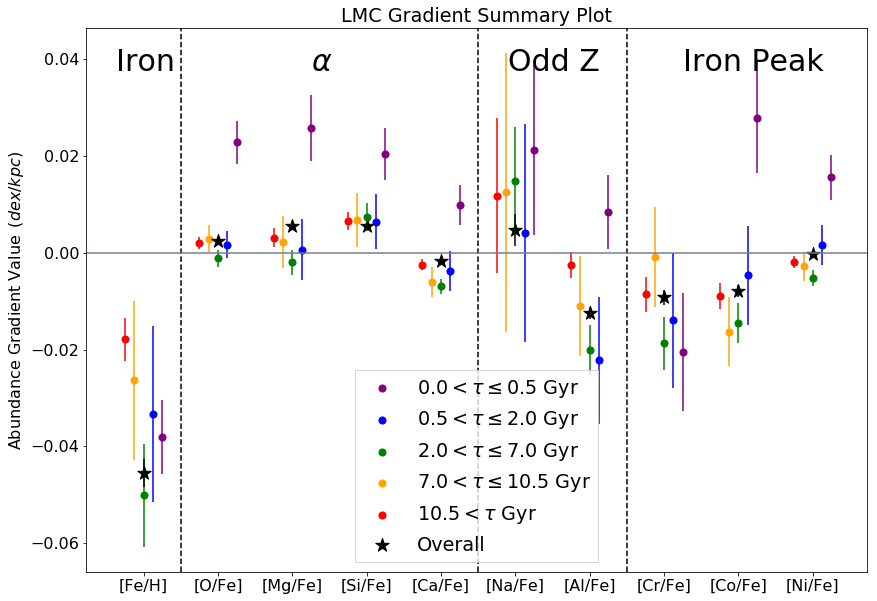

In [44]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]


# [np.squeeze(np.where(np.asarray(elems)=='O_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='AL_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='SI_FE')),np.squeeze(np.where(np.asarray(elems)=='CA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='CR_FE')),np.squeeze(np.where(np.asarray(elems)=='FE_H')),
#          np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(young_elems_slope[i])
    good_yless.append(yless_elems_slope[i])
    good_ymed.append(ymed_elems_slope[i])
    good_omed.append(omed_elems_slope[i])
    good_old.append(old_elems_slope[i])
    good_over.append(elems_slope[i])
    
    err_young.append(young_msm_devs[i])
    err_yless.append(yless_msm_devs[i])
    err_ymed.append(ymed_msm_devs[i])
    err_omed.append(omed_msm_devs[i])
    err_old.append(old_msm_devs[i])
    err_over.append(msm_devs[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[14,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0375,'Iron',fontsize=30)
plt.text(2.25,0.0375,'$\\alpha$',fontsize=30)
plt.text(4.9,0.0375,'Odd Z',fontsize=30)
plt.text(7.25,0.0375,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary Plot')

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
plt.savefig('grad_summary_errs_plot_withblueloop.pdf',bbox_inches='tight')
plt.show()

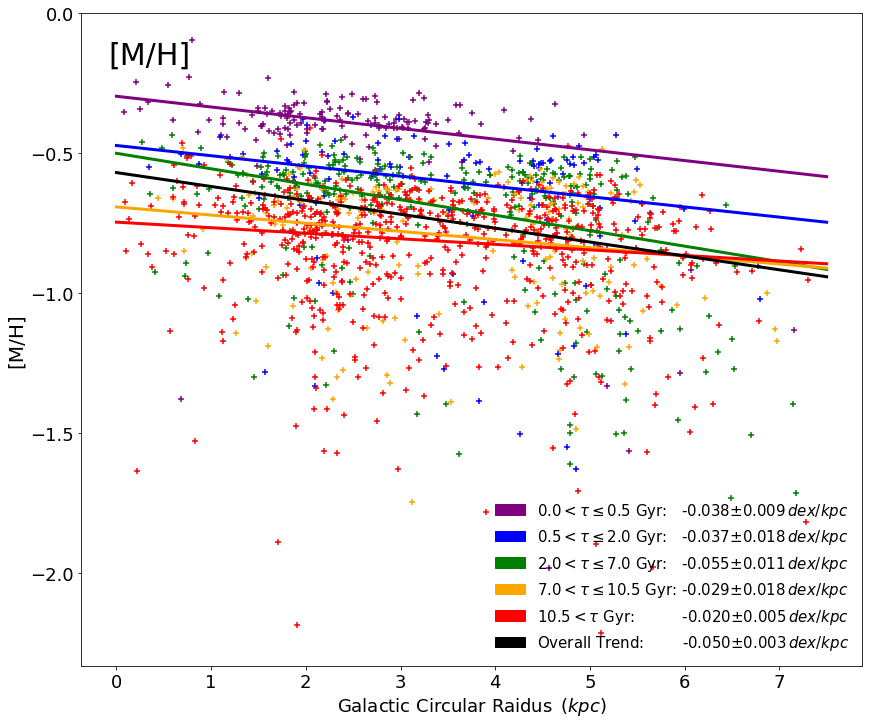

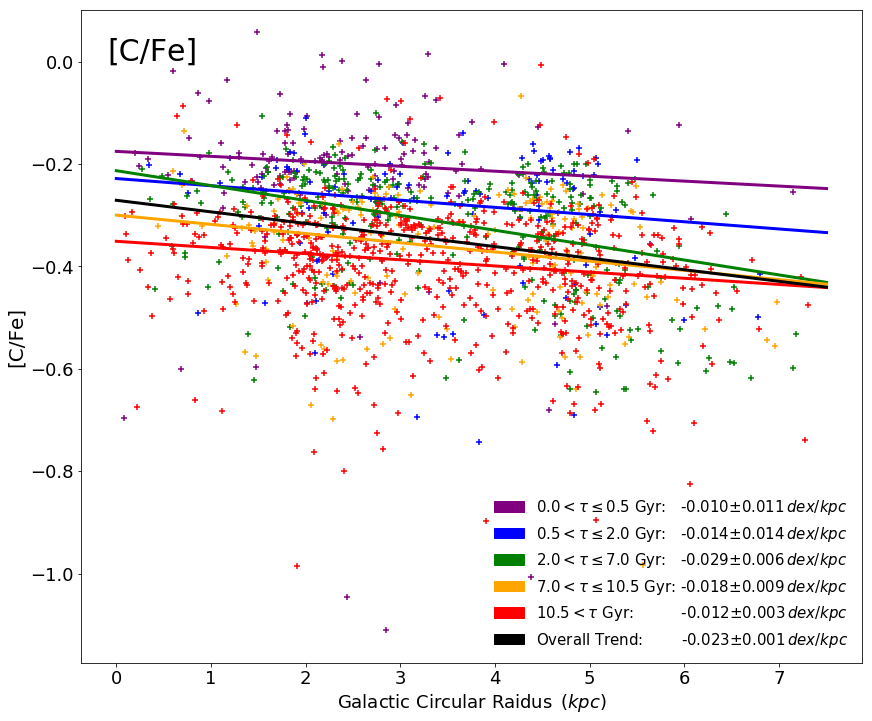

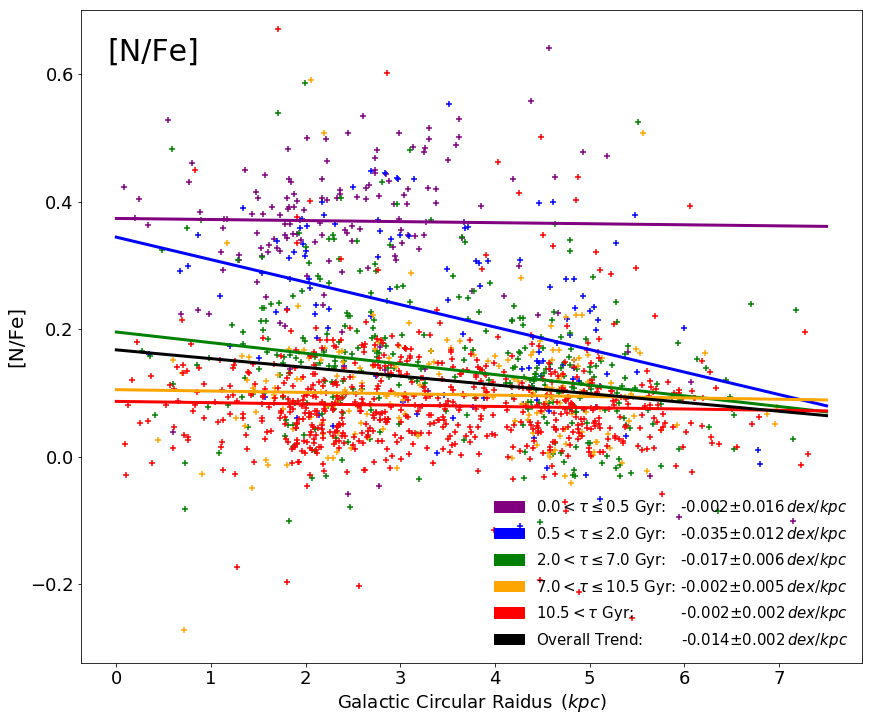

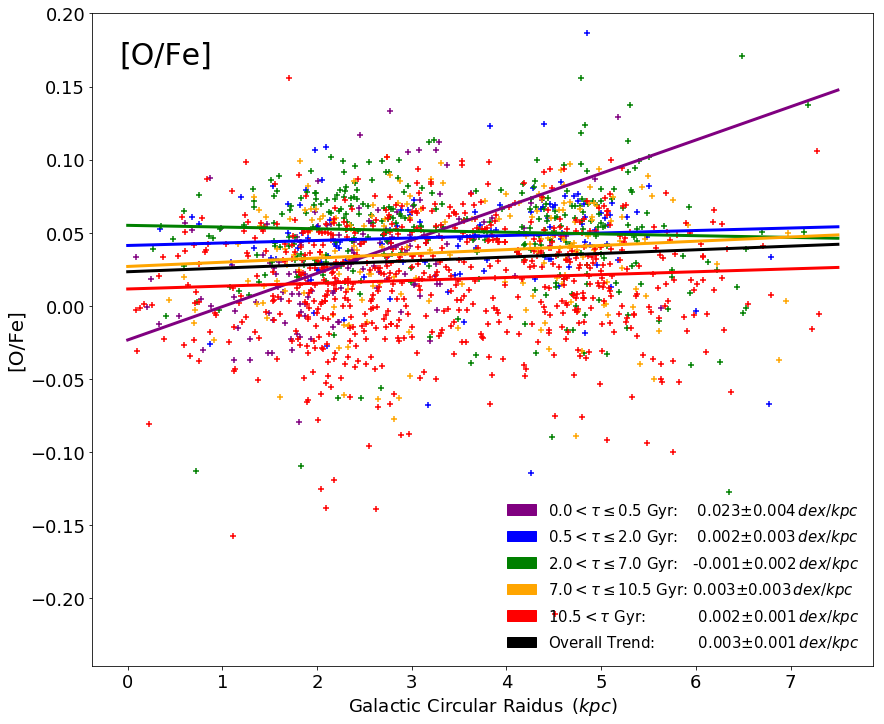

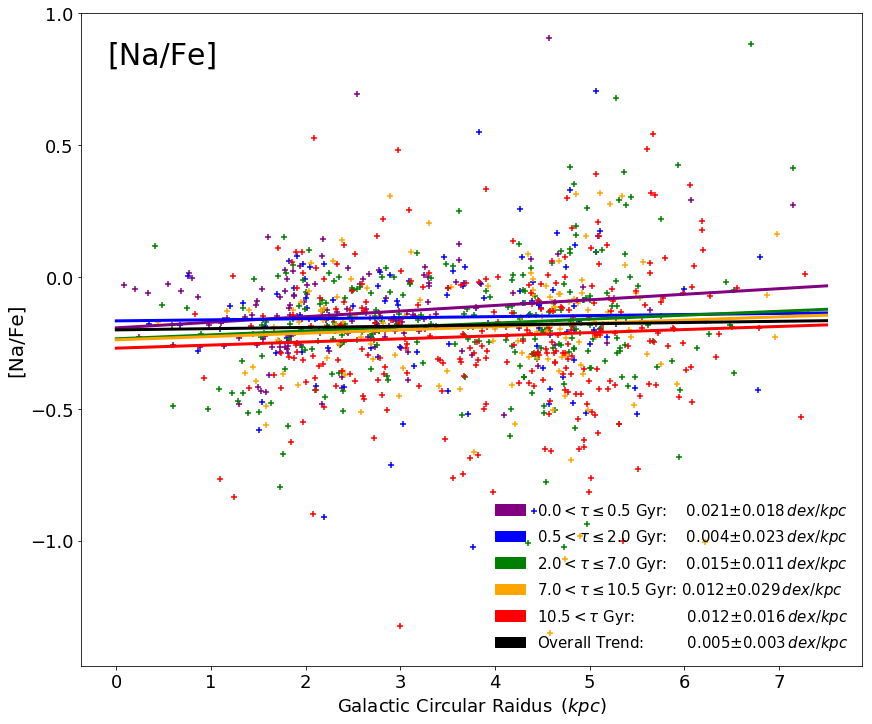

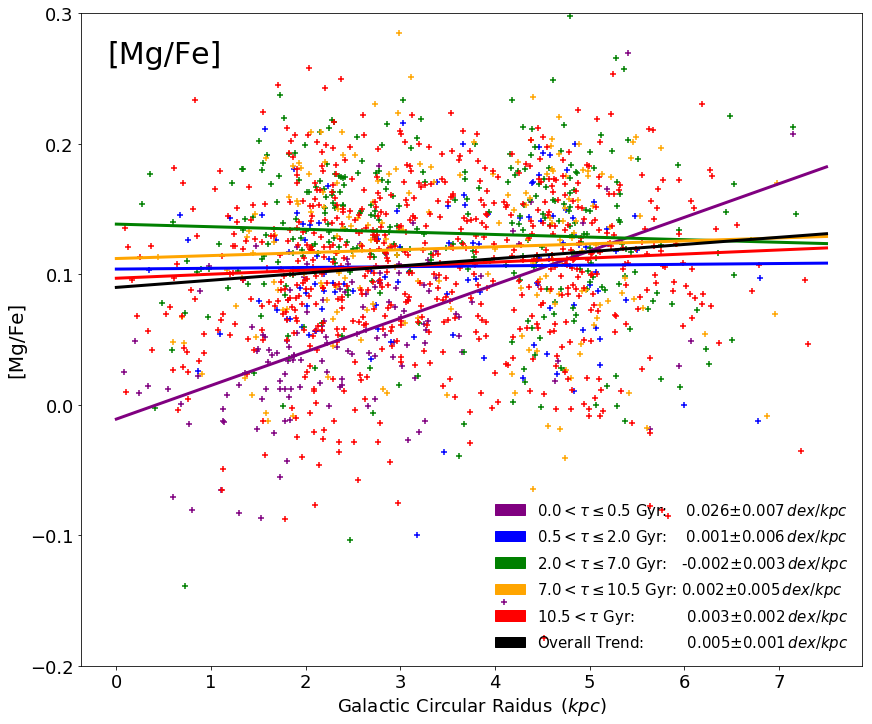

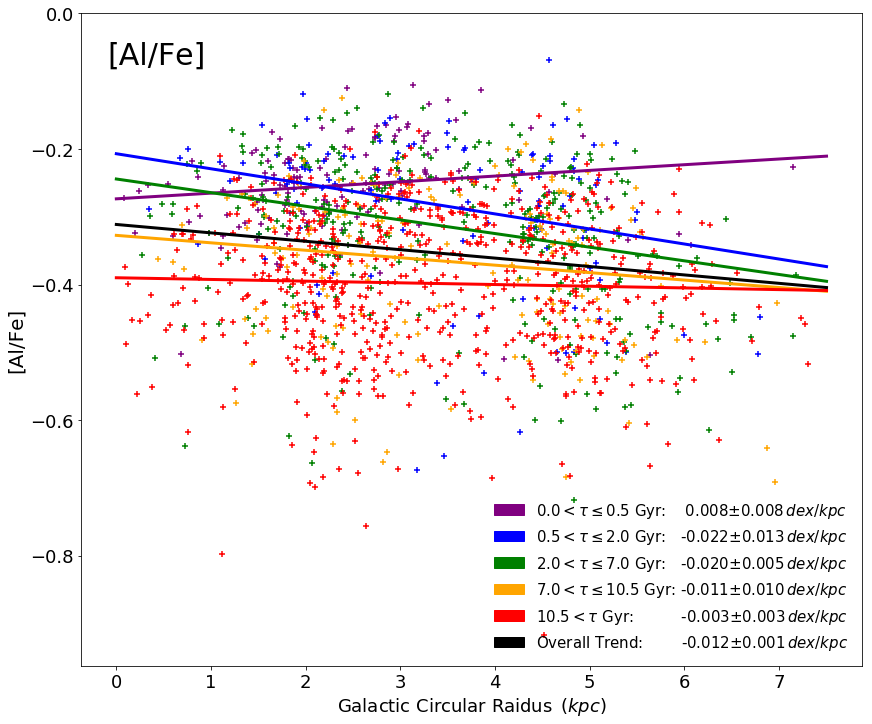

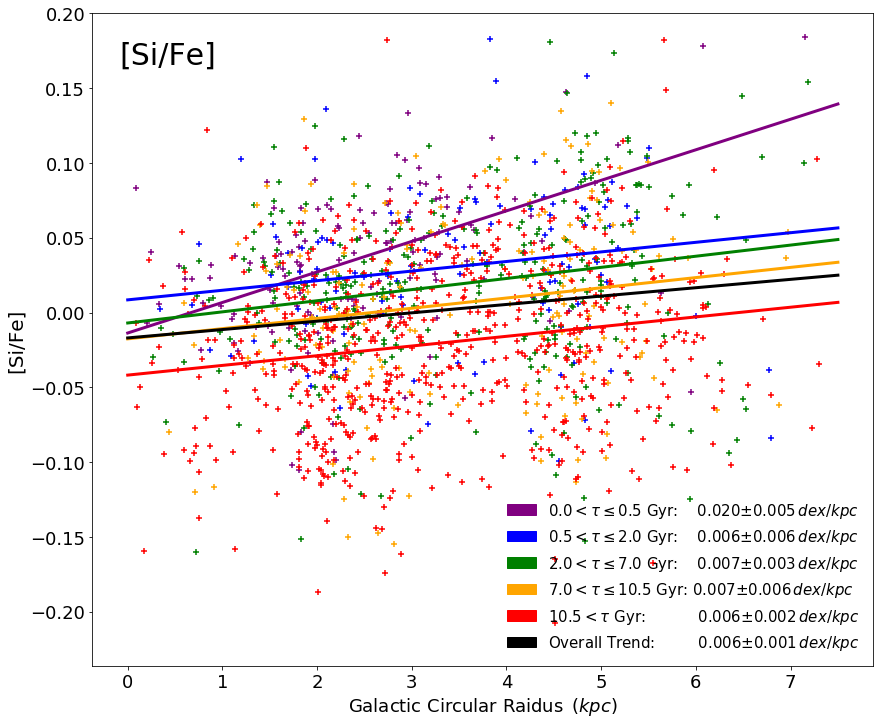

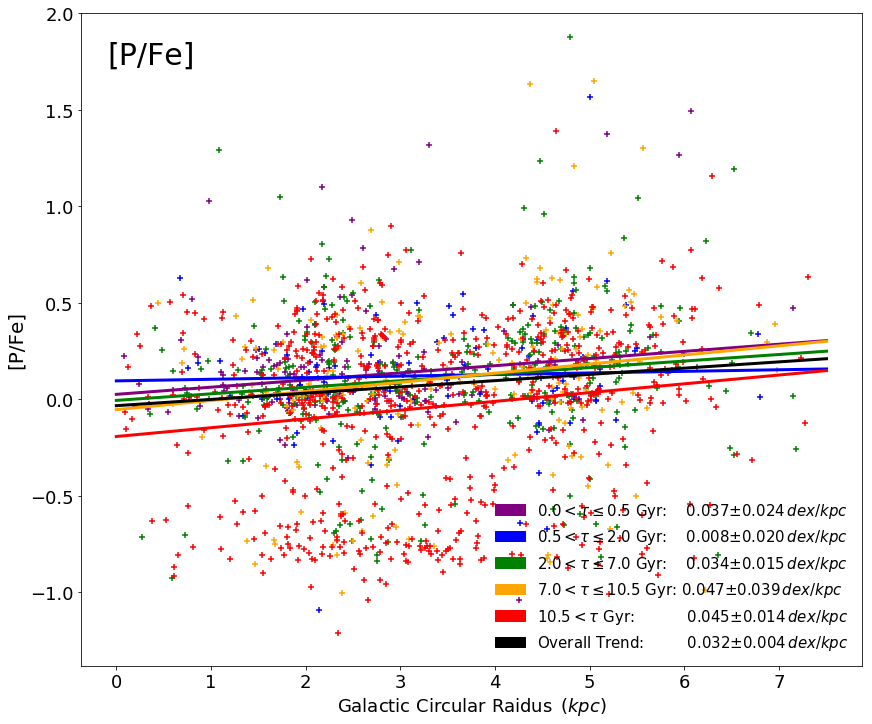

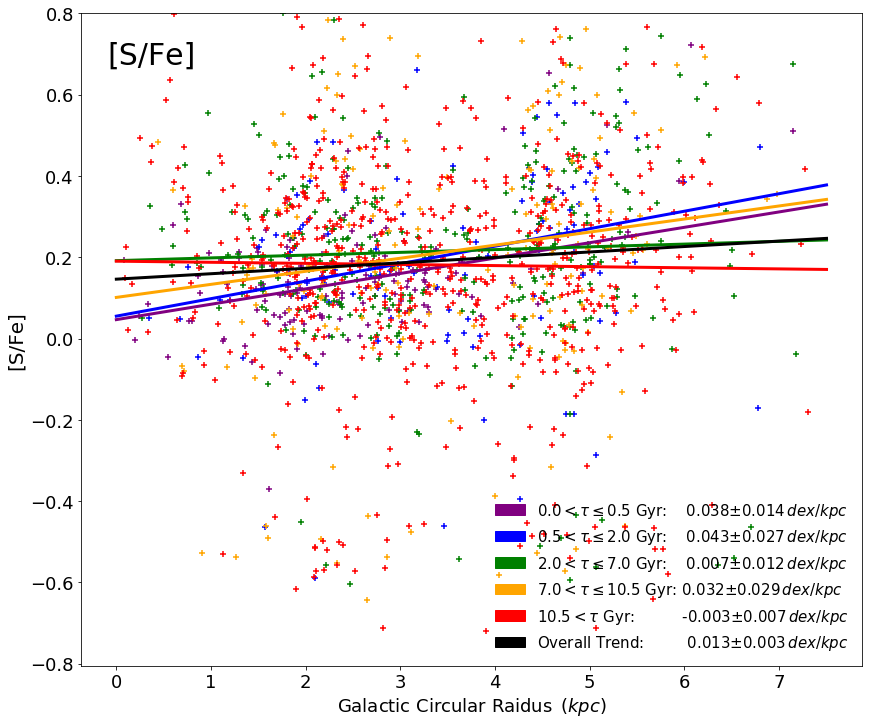

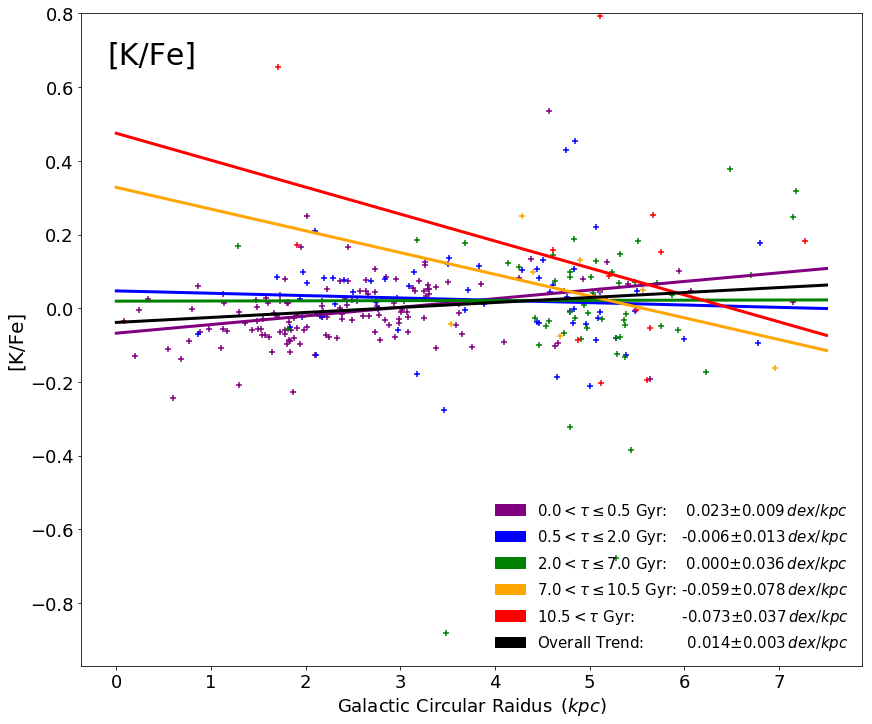

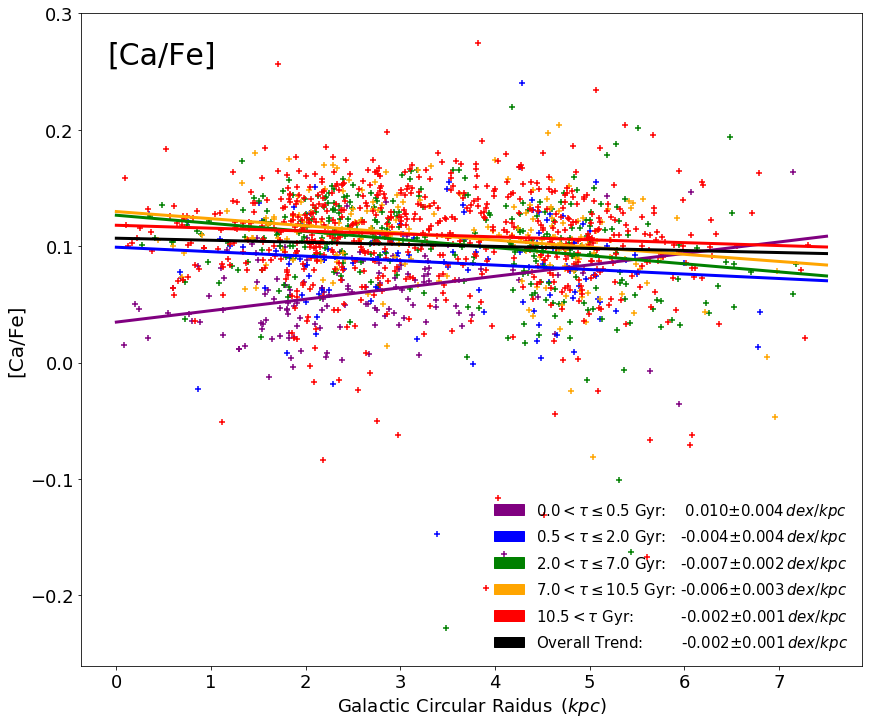

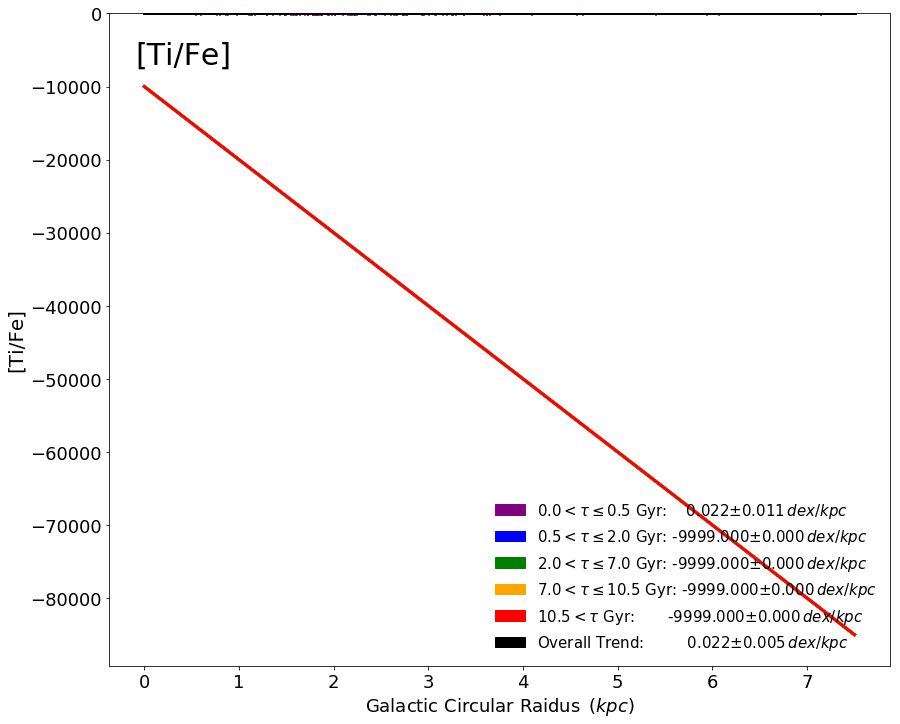

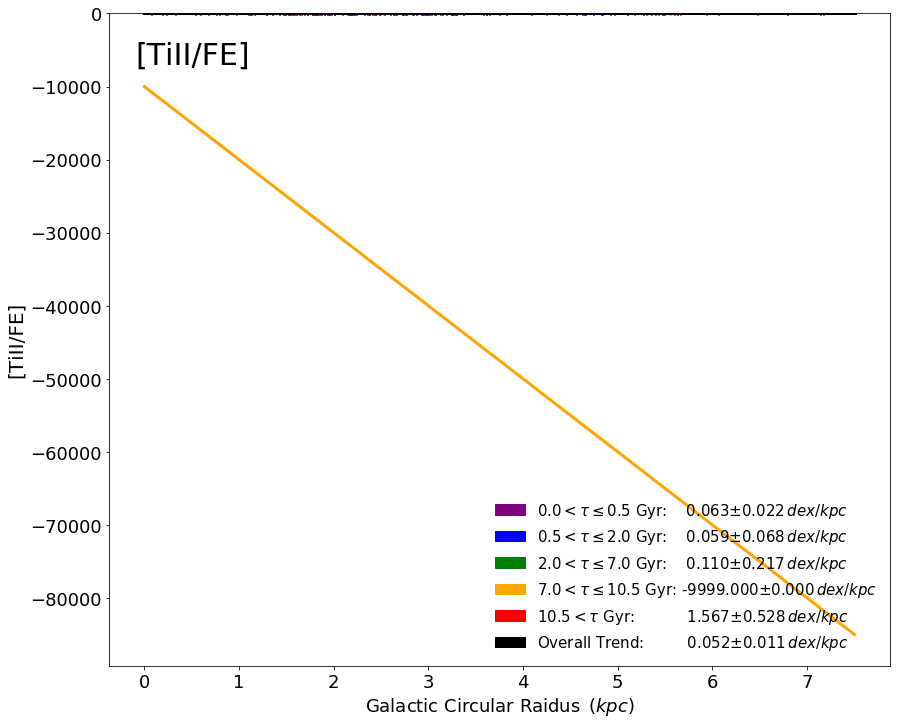

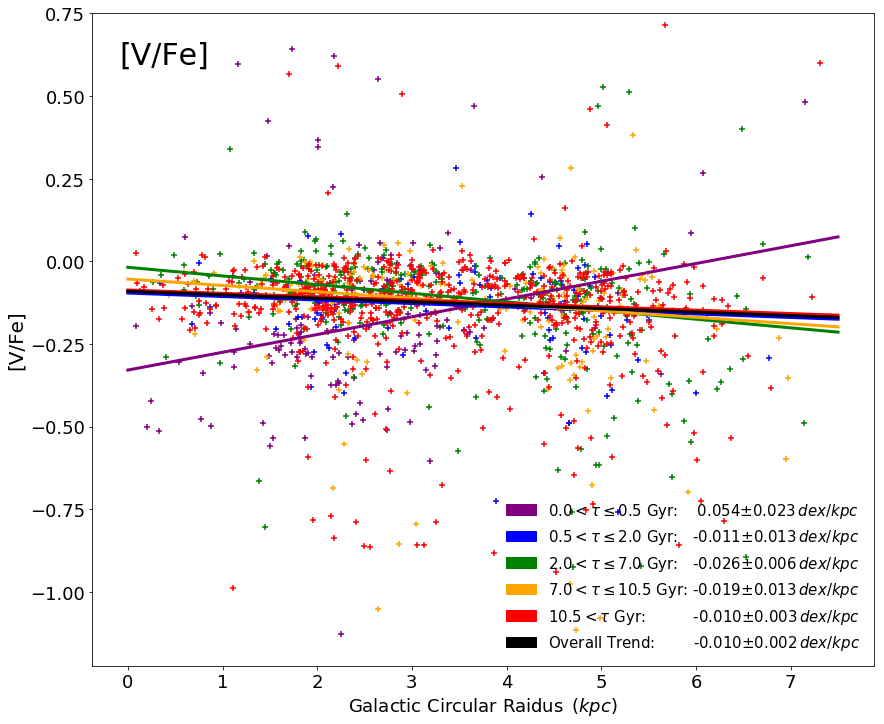

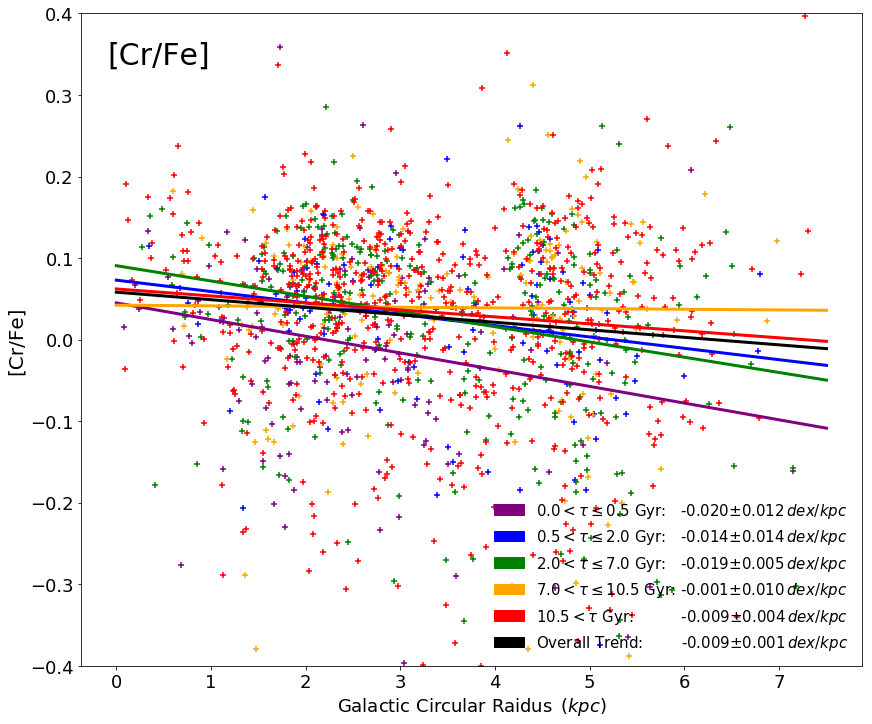

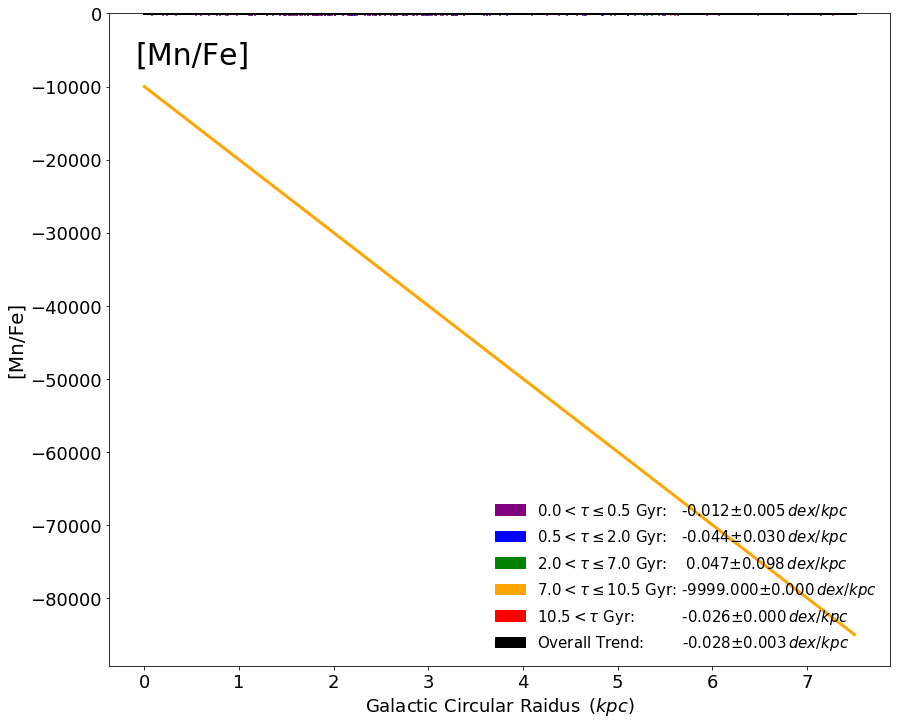

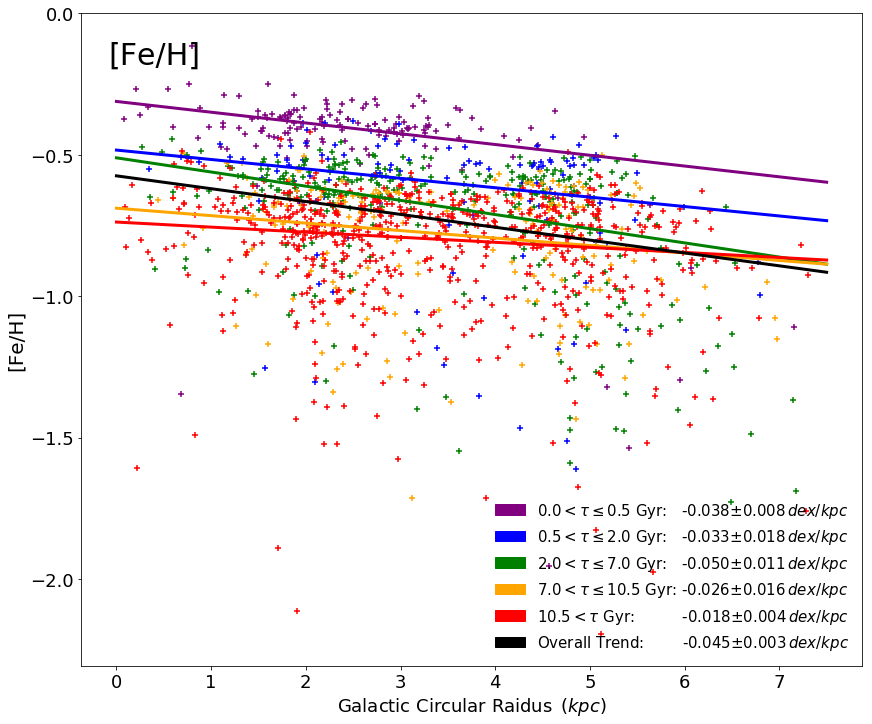

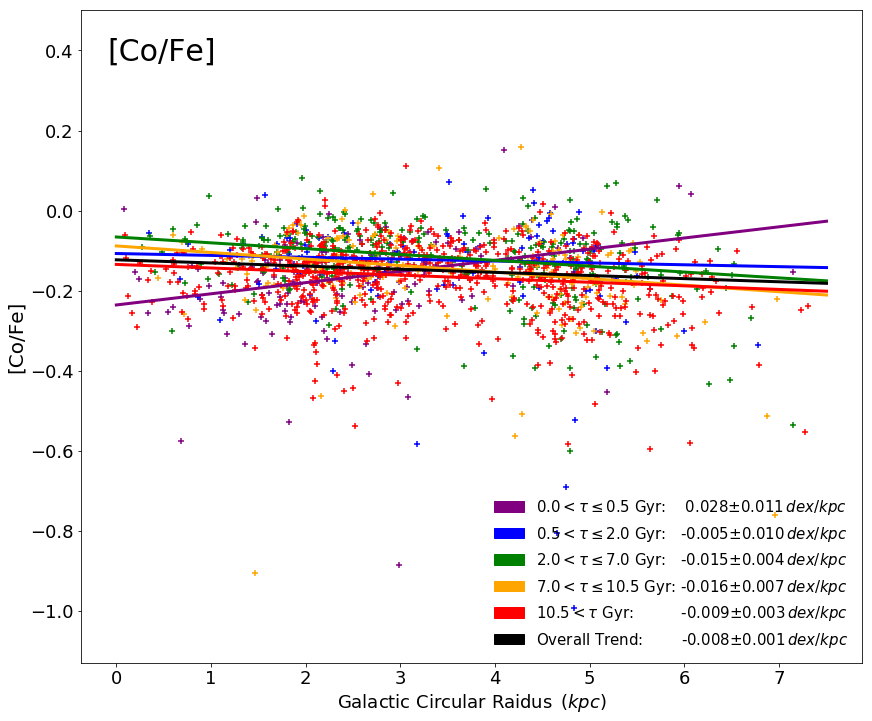

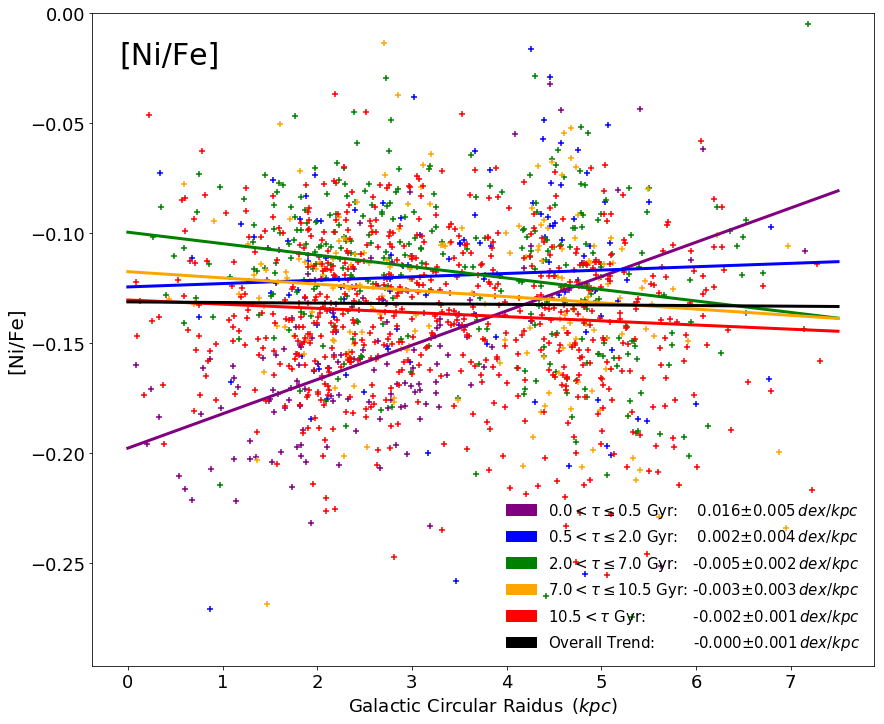

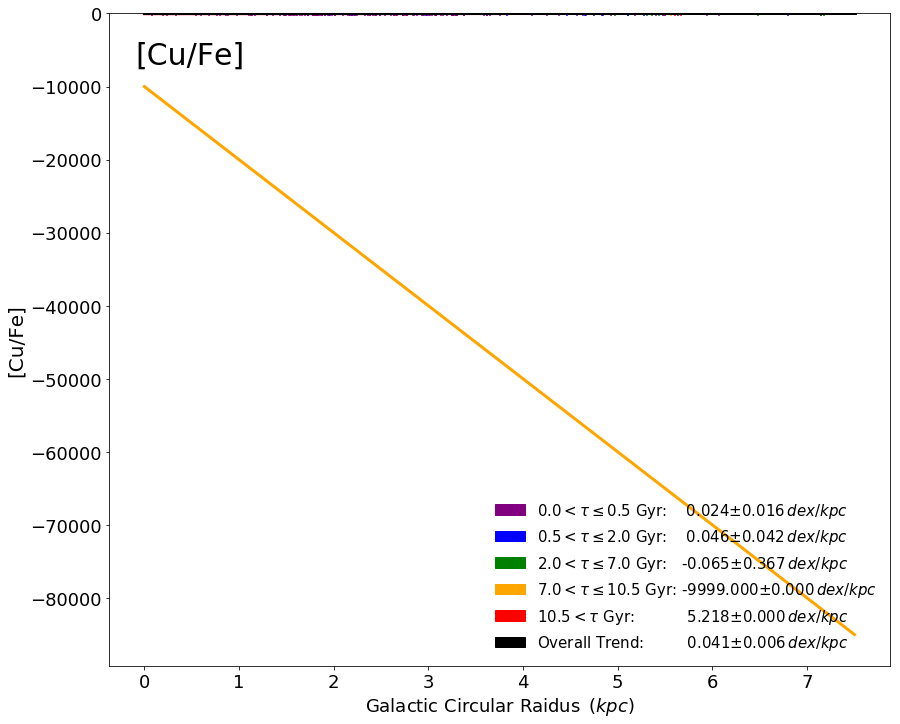

In [45]:
radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = parage[young]
yless_parage = parage[yless]
ymed_parage = parage[ymed]
omed_parage = parage[omed]
old_parage = parage[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return young_elems_slope[i]*x+young_elems_inter[i]
    def ylesstrendline(x):
        return yless_elems_slope[i]*x+yless_elems_inter[i]
    def ymedtrendline(x):
        return ymed_elems_slope[i]*x+ymed_elems_inter[i]
    def omedtrendline(x):
        return omed_elems_slope[i]*x+omed_elems_inter[i]
    def oldtrendline(x):
        return old_elems_slope[i]*x+old_elems_inter[i]
    
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    yless_cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100))
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])
    
    plt.scatter(np.asarray(radius)[young][young_cln],r13young[elems[i]][young_cln],
                marker='+',c='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0) #young
    
    plt.scatter(np.asarray(radius)[yless][yless_cln],r13yless[elems[i]][yless_cln],
                marker='+',c='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0) #yless
    
    plt.scatter(np.asarray(radius)[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],
                marker='+',c='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0) #ymed
    
    plt.scatter(np.asarray(radius)[omed][omed_cln],r13omed[elems[i]][omed_cln],
                marker='+',c='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0) #omed
    
    plt.scatter(np.asarray(radius)[old][old_cln],r13old[elems[i]][old_cln],
                marker='+',c='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0) #old
    
    ###Overall Trend
    def trendline(x):
        return elems_slope[i]*x+elems_inter[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(young_elems_slope[i],
                                                                                      young_msm_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(yless_elems_slope[i],
                                                                                      yless_msm_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(ymed_elems_slope[i],
                                                                                      ymed_msm_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$\pm {:.3f} \,dex/kpc$'.format(omed_elems_slope[i],
                                                                                       omed_msm_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$\pm {:.3f} \,dex/kpc$'.format(old_elems_slope[i],
                                                                               old_msm_devs[i]))
    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(elems_slope[i],
                                                                          msm_devs[i]))
    
    plt.legend(handles,labels,loc='lower right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    plt.ylim(top = ytops[i])
    
    if elems[i] == 'CR_FE':
        plt.ylim(bottom = -0.4)
        
    if elems[i] == 'MG_FE':
        plt.ylim(-0.2, 0.3)
        
    if elems[i] == 'SI_FE':
        plt.ylim(top = 0.2)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.savefig('age_abund_withblueloop_grad{}.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

## With Blue Loop with Medians

In [118]:
### young
young_stats = [] 
young_edges = []
young_number = []

for i in range(len(elems)-5):
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusyoung[young_cln])),np.ceil(np.max(radiusyoung[young_cln])),1)
        young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(radiusyoung[young_cln],
                                                                             r13young[elems[i]][young_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_edges.append(young_bin_edges)
        young_number.append(young_binnumber)
    
    except:
        young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

        
### yless        
yless_stats = [] 
yless_edges = []
yless_number = []

for i in range(len(elems)-5):
    yless_cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusyless[yless_cln])),np.ceil(np.max(radiusyless[yless_cln])),1)
        yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(radiusyless[yless_cln],
                                                                             r13yless[elems[i]][yless_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_edges.append(yless_bin_edges)
        yless_number.append(yless_binnumber)
    
    except:
        yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### ymed       
ymed_stats = [] 
ymed_edges = []
ymed_number = []

for i in range(len(elems)-5):
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusymed[ymed_cln])),np.ceil(np.max(radiusymed[ymed_cln])),1)
        ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(radiusymed[ymed_cln],
                                                                             r13ymed[elems[i]][ymed_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_edges.append(ymed_bin_edges)
        ymed_number.append(ymed_binnumber)
    
    except:
        ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### omed       
omed_stats = [] 
omed_edges = []
omed_number = []

for i in range(len(elems)-5):
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusomed[omed_cln])),np.ceil(np.max(radiusomed[omed_cln])),1)
        omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(radiusomed[omed_cln],
                                                                             r13omed[elems[i]][omed_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_edges.append(omed_bin_edges)
        omed_number.append(omed_binnumber)
    
    except:
        omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### old       
old_stats = [] 
old_edges = []
old_number = []

for i in range(len(elems)-5):
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(radiusold[old_cln])),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(radiusold[old_cln],
                                                                             r13old[elems[i]][old_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
    
    except:
        old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

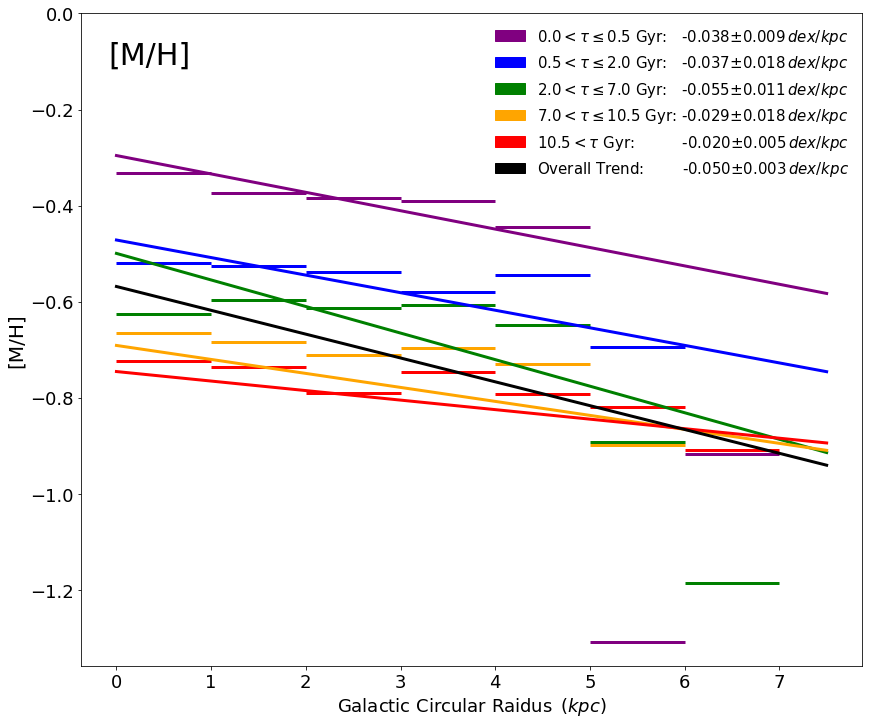

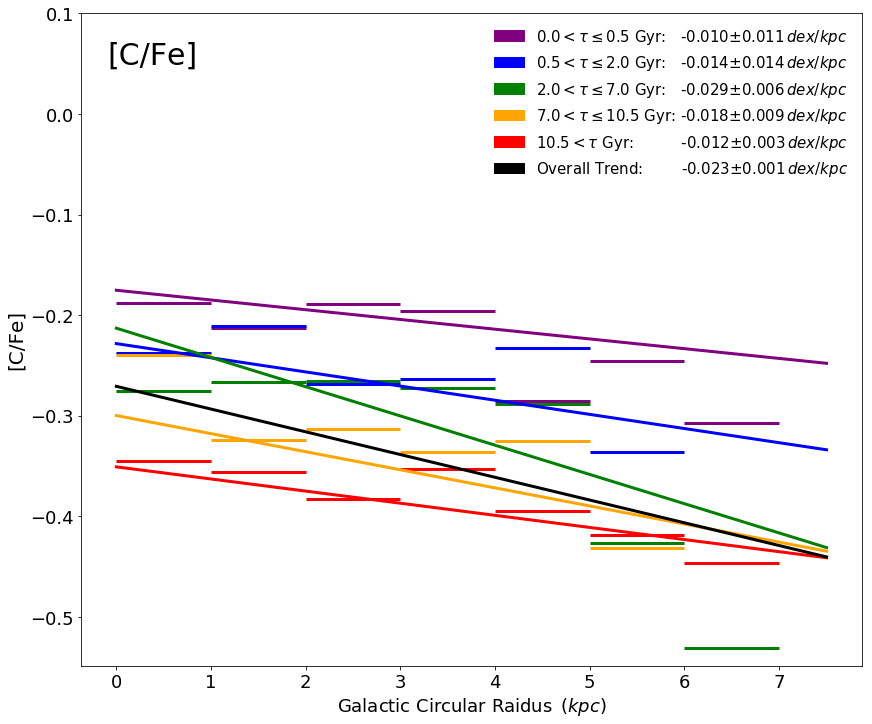

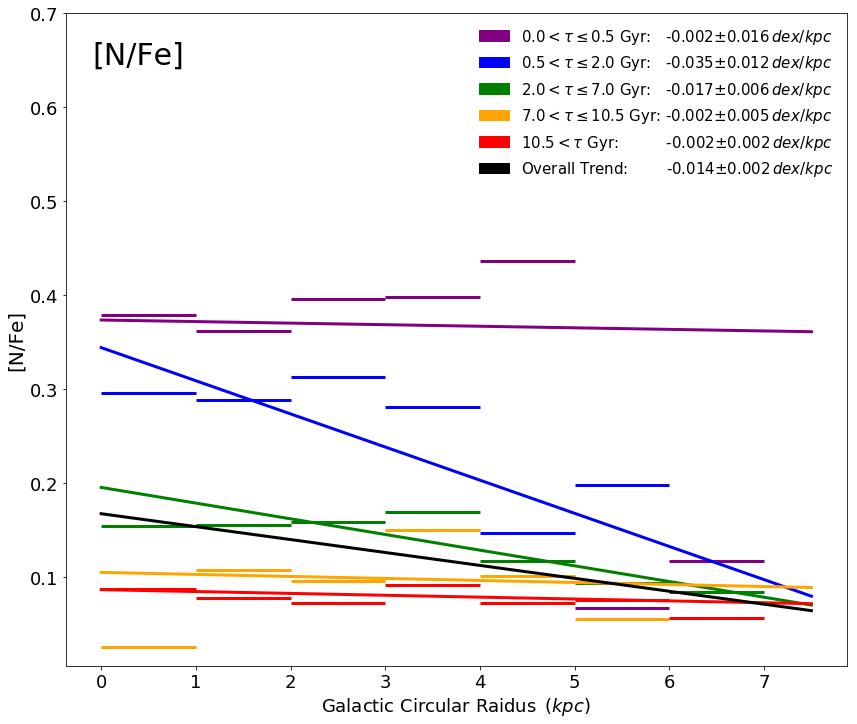

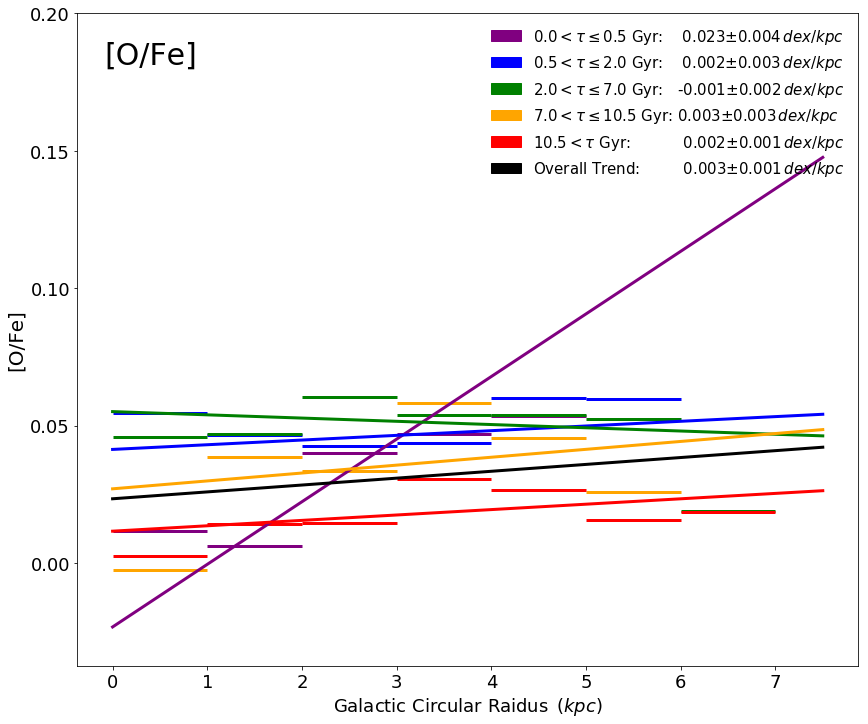

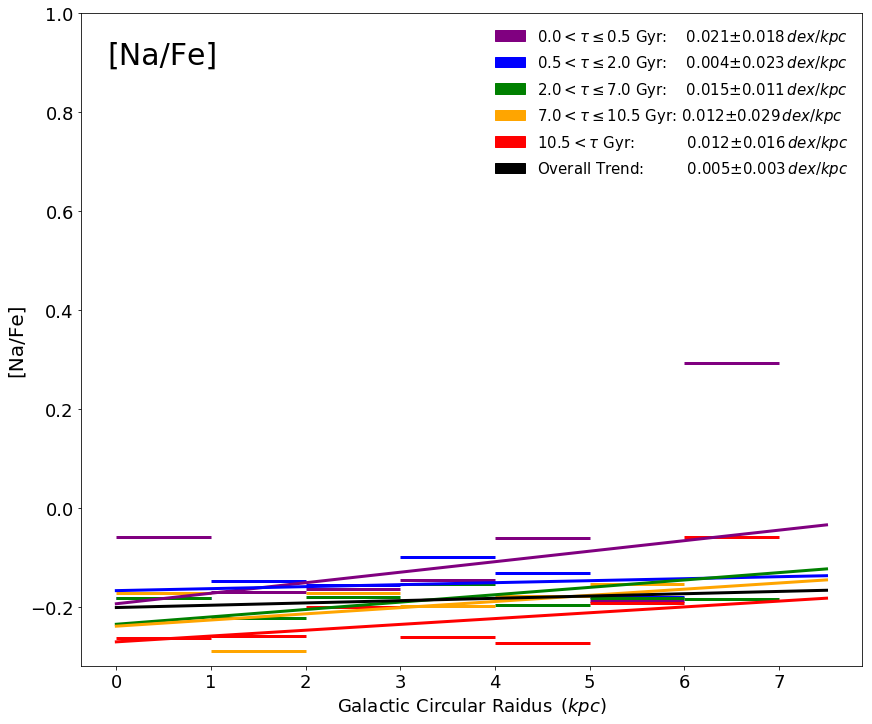

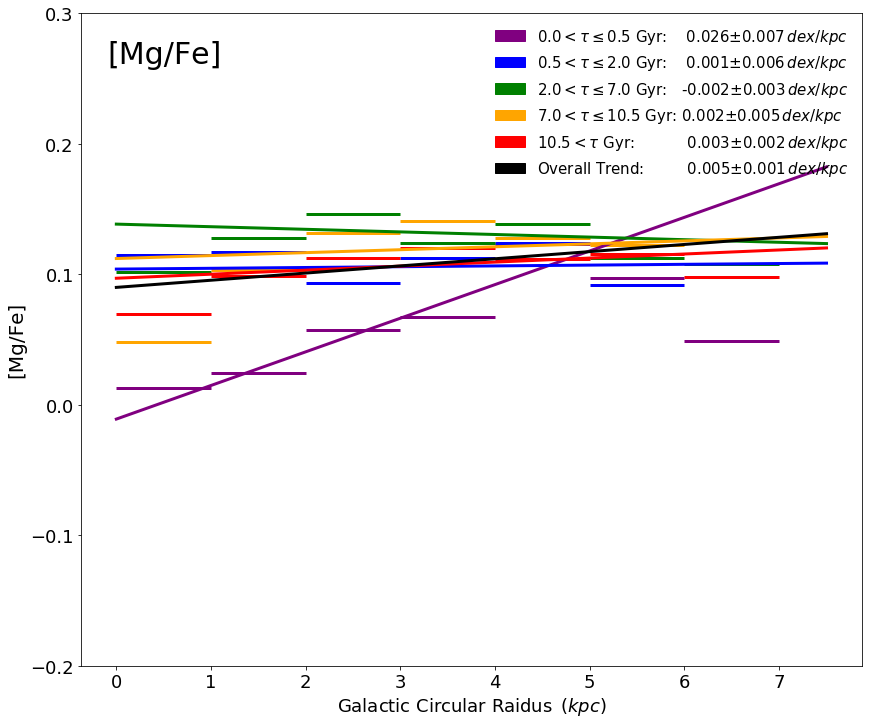

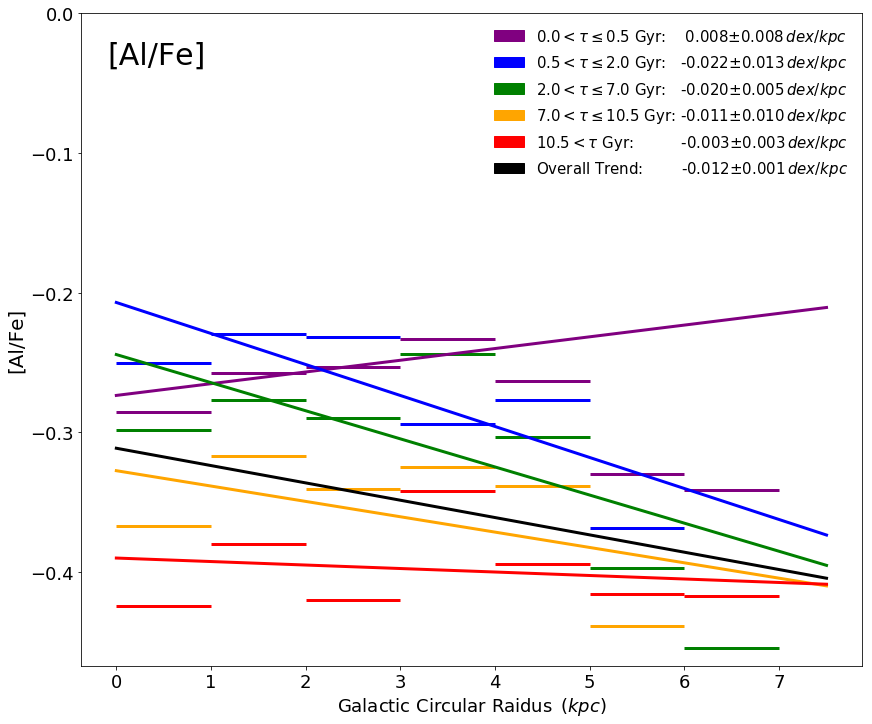

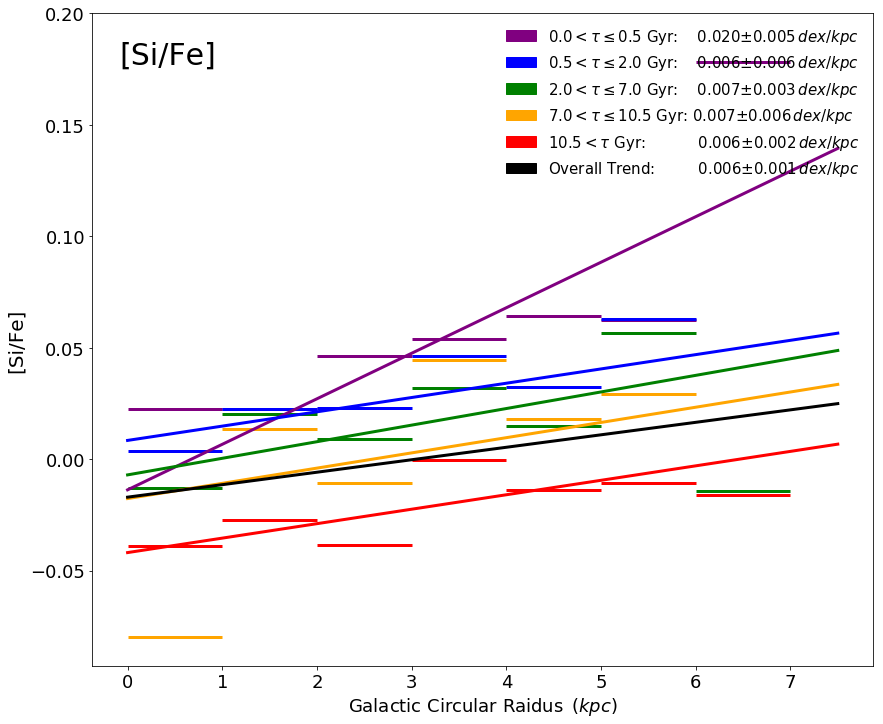

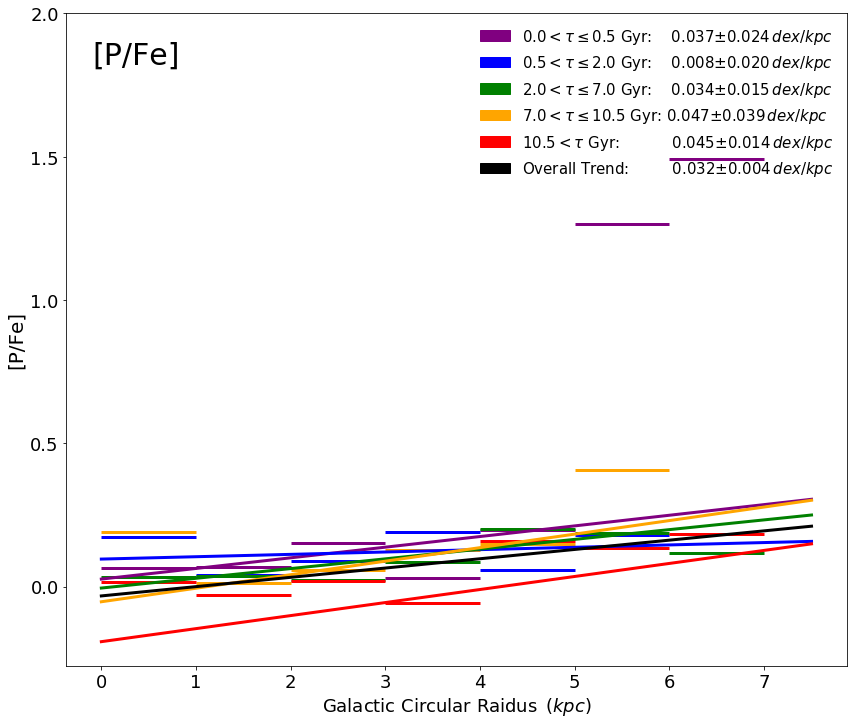

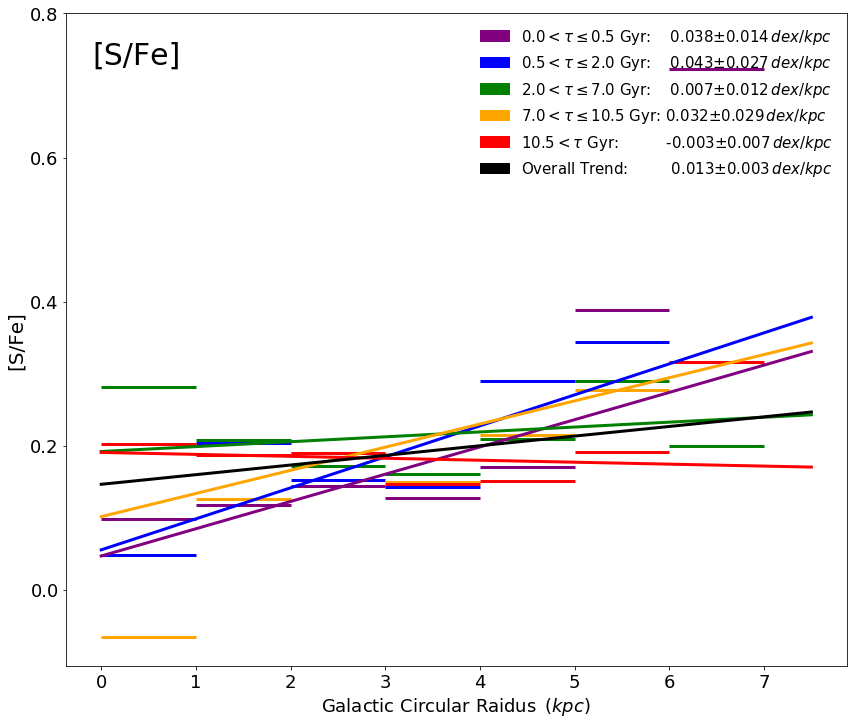

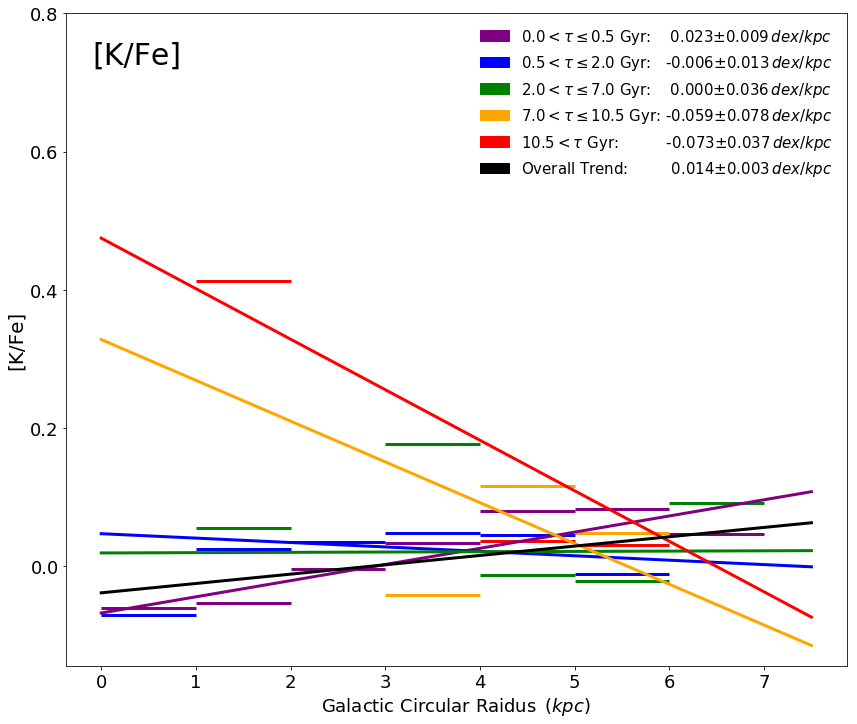

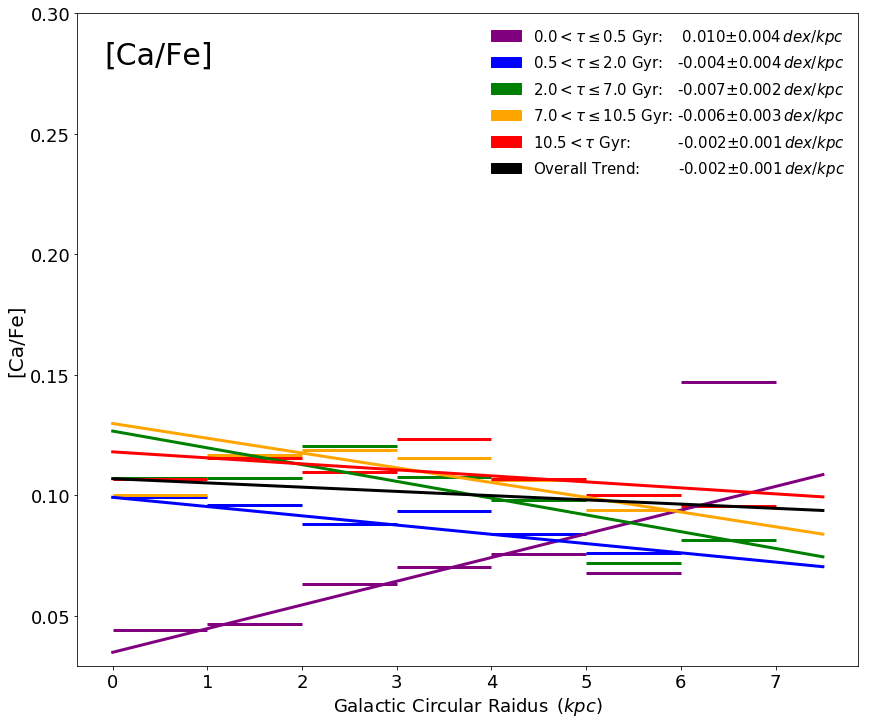

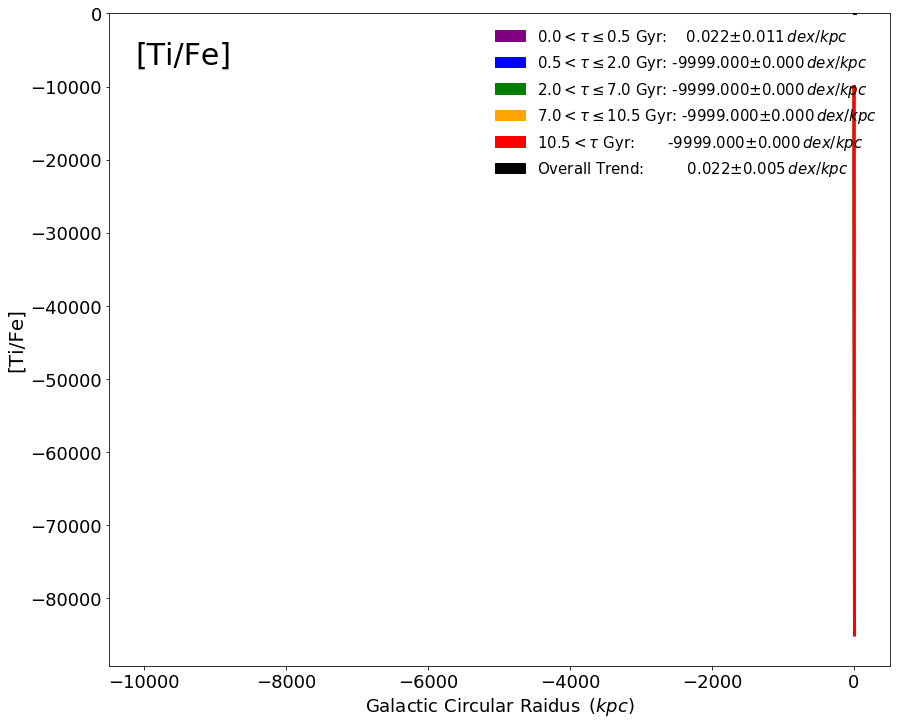

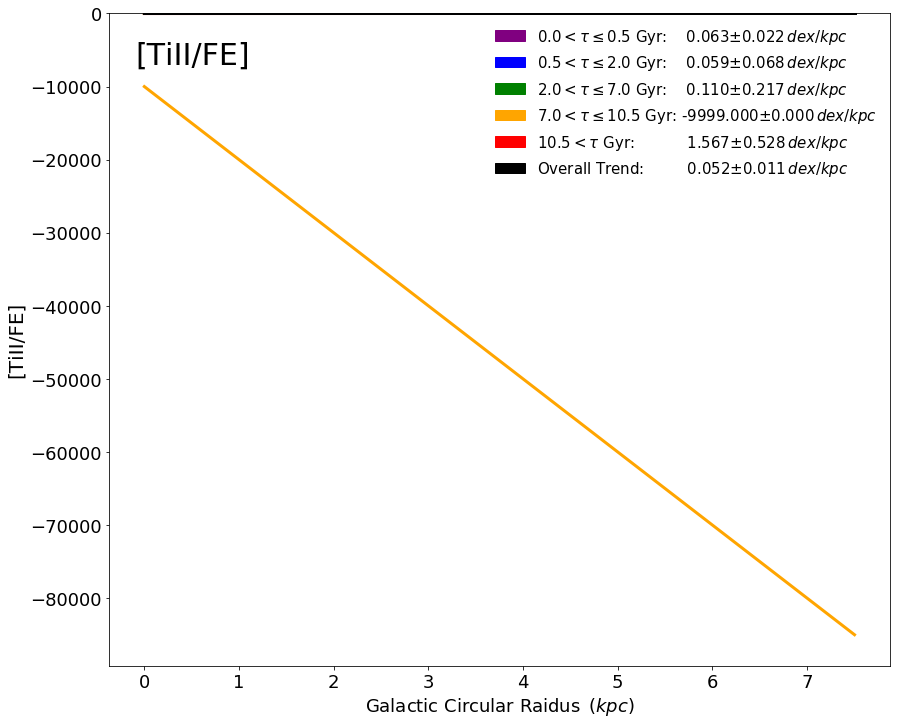

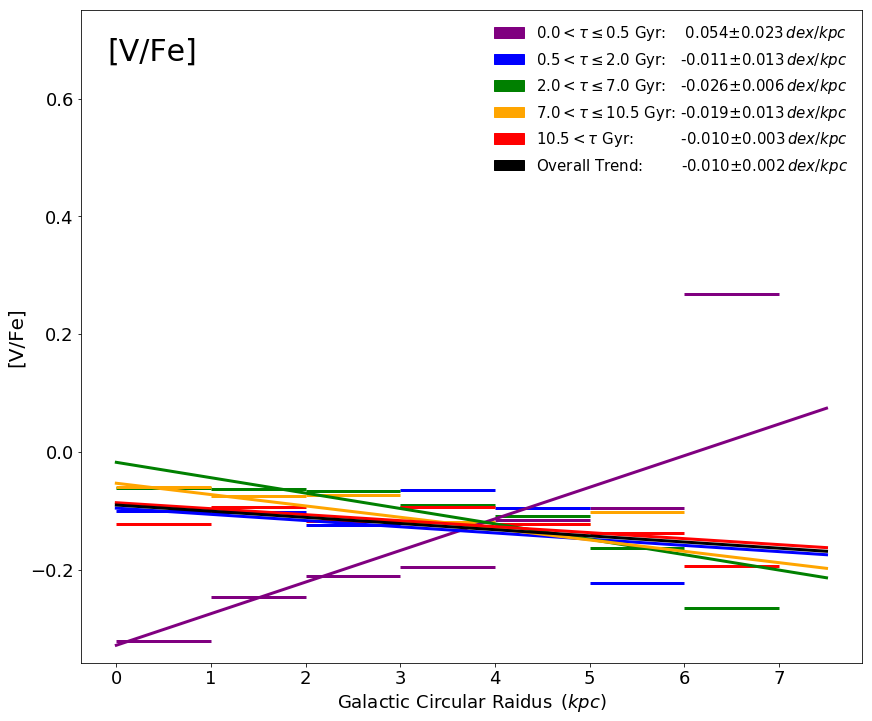

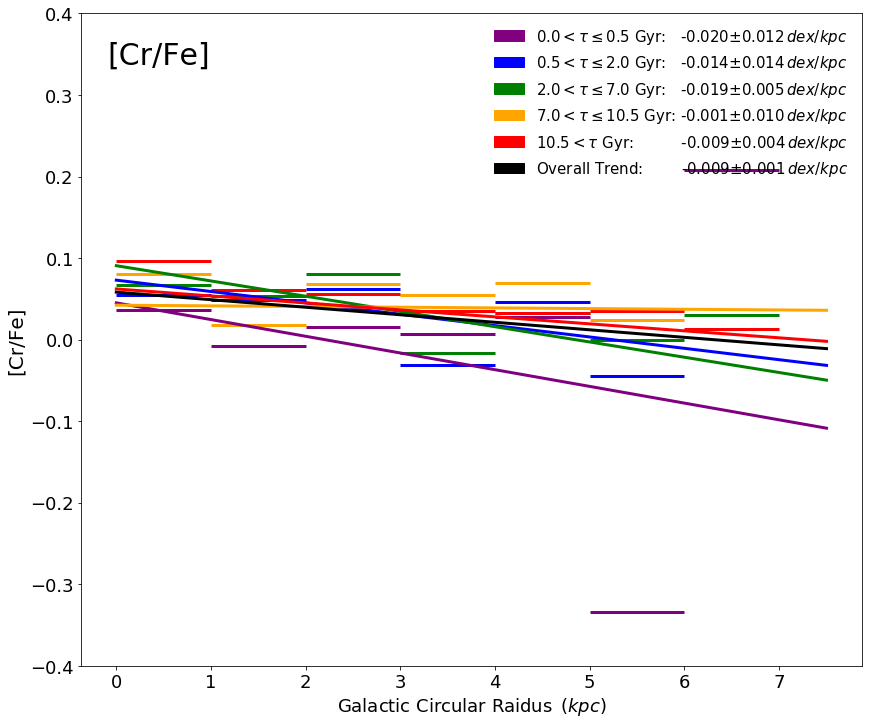

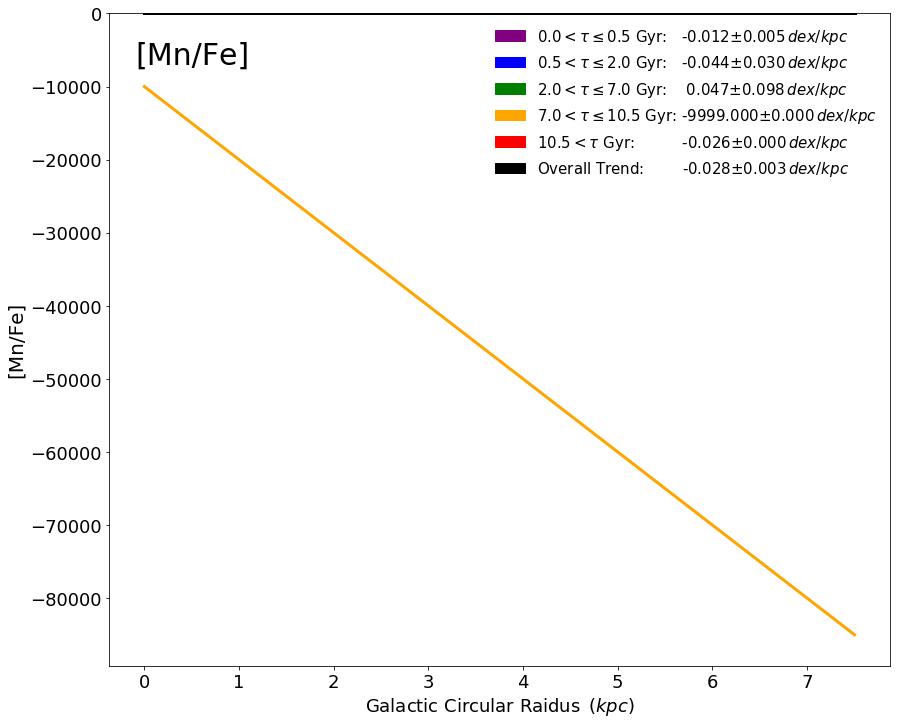

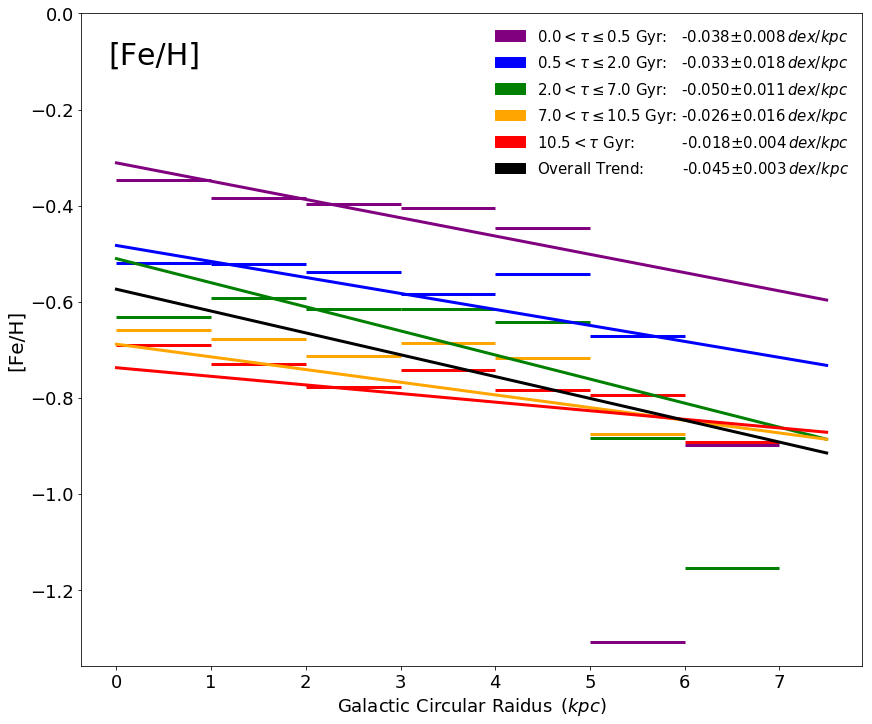

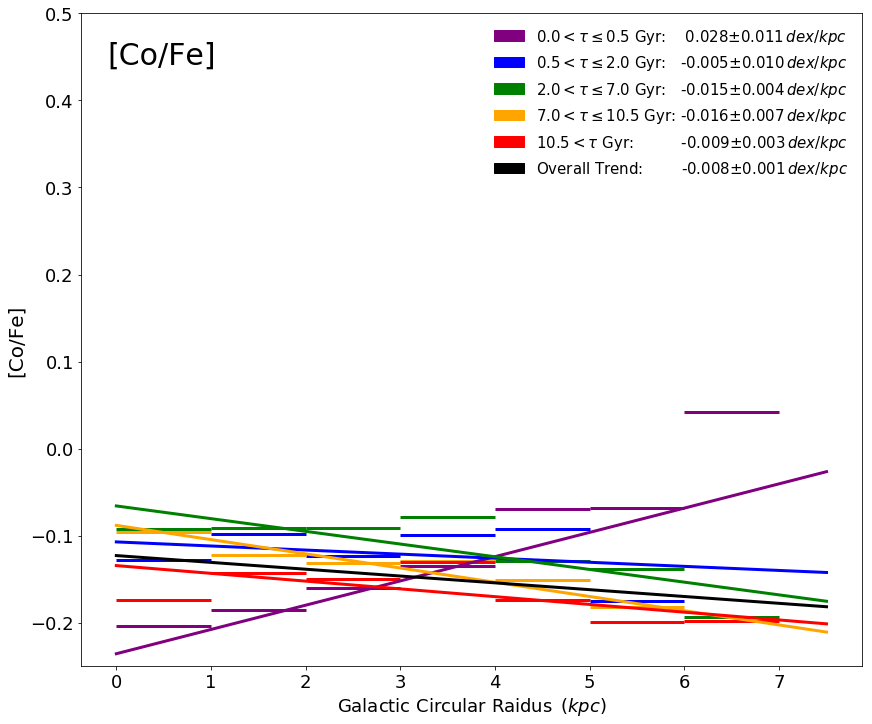

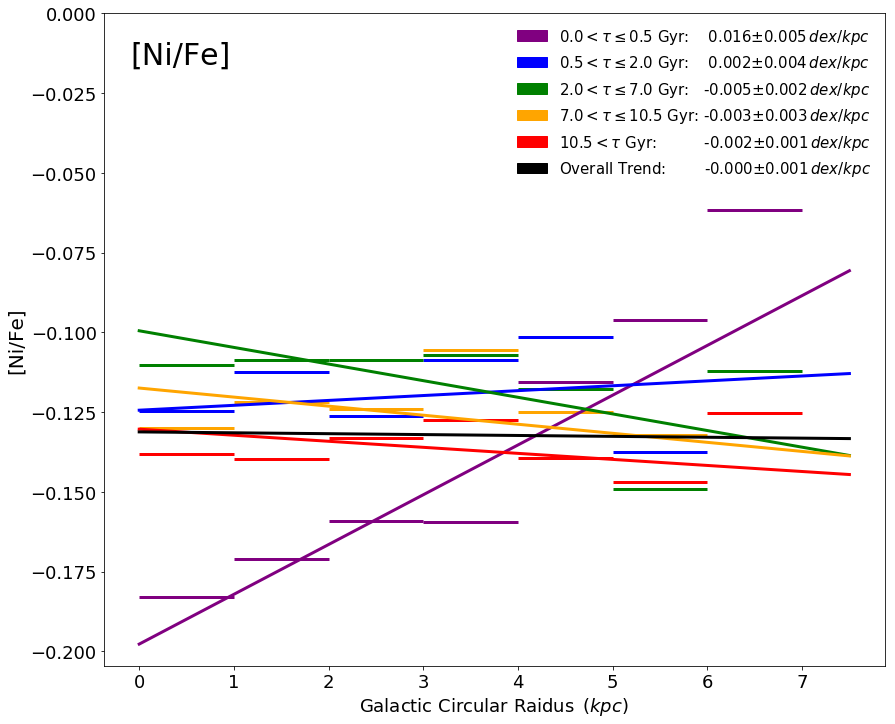

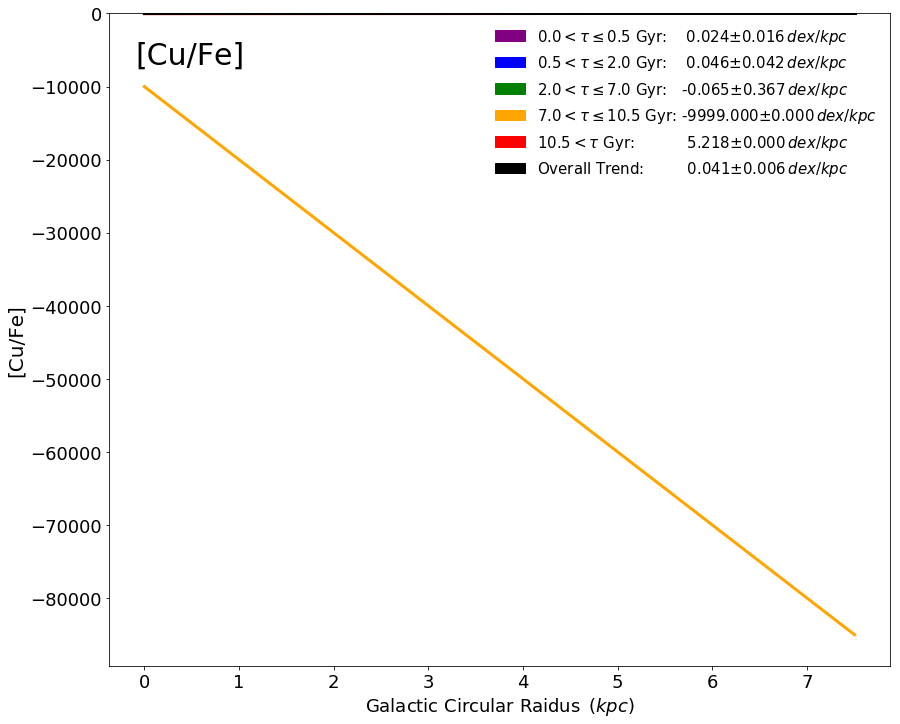

In [134]:
radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = parage[young]
yless_parage = parage[yless]
ymed_parage = parage[ymed]
omed_parage = parage[omed]
old_parage = parage[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return young_elems_slope[i]*x+young_elems_inter[i]
    def ylesstrendline(x):
        return yless_elems_slope[i]*x+yless_elems_inter[i]
    def ymedtrendline(x):
        return ymed_elems_slope[i]*x+ymed_elems_inter[i]
    def omedtrendline(x):
        return omed_elems_slope[i]*x+omed_elems_inter[i]
    def oldtrendline(x):
        return old_elems_slope[i]*x+old_elems_inter[i]
    
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    yless_cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100))
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])
    
    plt.hlines(young_stats[i],young_edges[i][:-1],young_edges[i][1:],colors='purple',lw=3.0)
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='-') #young
    
    plt.hlines(yless_stats[i],yless_edges[i][:-1],yless_edges[i][1:],colors='blue',lw=3.0)
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='-') #yless
    
    plt.hlines(ymed_stats[i],ymed_edges[i][:-1],ymed_edges[i][1:],colors='green',lw=3.0)
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='-') #ymed
    
    plt.hlines(omed_stats[i],omed_edges[i][:-1],omed_edges[i][1:],colors='orange',lw=3.0)
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='-') #omed
    
    plt.hlines(old_stats[i],old_edges[i][:-1],old_edges[i][1:],colors='red',lw=3.0)
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='-') #old
    
    ###Overall Trend
    def trendline(x):
        return elems_slope[i]*x+elems_inter[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(young_elems_slope[i],
                                                                                      young_msm_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(yless_elems_slope[i],
                                                                                      yless_msm_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(ymed_elems_slope[i],
                                                                                      ymed_msm_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$\pm {:.3f} \,dex/kpc$'.format(omed_elems_slope[i],
                                                                                       omed_msm_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$\pm {:.3f} \,dex/kpc$'.format(old_elems_slope[i],
                                                                               old_msm_devs[i]))
    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(elems_slope[i],
                                                                          msm_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    plt.ylim(top = ytops[i])
    
    if elems[i] == 'CR_FE':
        plt.ylim(bottom = -0.4)
        
    if elems[i] == 'MG_FE':
        plt.ylim(-0.2, 0.3)
        
    if elems[i] == 'SI_FE':
        plt.ylim(top = 0.2)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.savefig('med_age_abund_withblueloop_grad{}.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

## Without Blue loop with medians

In [ ]:
### old
bloop_old_stats = [] 
bloop_old_edges = []
bloop_old_number = []

for i in range(len(elems)-5):
    bloop_old_cln = np.where((bloop_r13old[elems[i]]>-100)&(bloop_r13old['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(bloop_radiusold[old_cln])),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(bloop_radiusold[old_cln],
                                                                             bloop_r13old[elems[i]][old_cln],
                                                                             statistic='median',bins=bins)
                                                                        
        bloop_old_stats.append(old_bin_stats)
        bloop_old_edges.append(old_bin_edges)
        bloop_old_number.append(old_binnumber)
    
    except:
        bloop_old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        bloop_old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        bloop_old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

In [144]:
### young
bloop_young_stats = [] 
bloop_young_edges = []
bloop_young_number = []

for i in range(len(elems)-5):
    bloop_young_cln = np.where((bloop_r13young[elems[i]]>-100)&(bloop_r13young['SNR']>=100))
    print(bloop_young_cln)
#     try:
#         bins = np.arange(np.floor(np.min(bloop_radiusyoung[young_cln])),np.ceil(np.max(bloop_radiusyoung[young_cln])),1)
#         young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(bloop_radiusyoung[young_cln],
#                                                                              bloop_r13young[elems[i]][young_cln],
#                                                                              statistic='median',bins=bins)
                                                                        
#         bloop_young_stats.append(young_bin_stats)
#         bloop_young_edges.append(young_bin_edges)
#         bloop_young_number.append(young_binnumber)
    
#     except:
#         bloop_young_stats.append(np.multiply(-9999.0,np.ones(len(bins))))
#         bloop_young_edges.append(np.multiply(-9999.0,np.ones(len(bins))))
#         bloop_young_number.append(np.multiply(-9999.0,np.ones(len(bins))))

        
# ### yless
# bloop_yless_stats = [] 
# bloop_yless_edges = []
# bloop_yless_number = []

# for i in range(len(elems)-5):
#     bloop_yless_cln = np.where((bloop_r13yless[elems[i]]>-100)&(bloop_r13yless['SNR']>=100))
#     try:
#         bins = np.arange(np.floor(np.min(bloop_radiusyless[yless_cln])),np.ceil(np.max(bloop_radiusyless[yless_cln])),1)
#         yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(bloop_radiusyless[yless_cln],
#                                                                              bloop_r13yless[elems[i]][yless_cln],
#                                                                              statistic='median',bins=bins)
                                                                        
#         bloop_yless_stats.append(yless_bin_stats)
#         bloop_yless_edges.append(yless_bin_edges)
#         bloop_yless_number.append(yless_binnumber)
    
#     except:
#         bloop_yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
# ### ymed
# bloop_ymed_stats = [] 
# bloop_ymed_edges = []
# bloop_ymed_number = []

# for i in range(len(elems)-5):
#     bloop_ymed_cln = np.where((bloop_r13ymed[elems[i]]>-100)&(bloop_r13ymed['SNR']>=100))
#     try:
#         bins = np.arange(np.floor(np.min(bloop_radiusymed[ymed_cln])),np.ceil(np.max(bloop_radiusymed[ymed_cln])),1)
#         ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(bloop_radiusymed[ymed_cln],
#                                                                              bloop_r13ymed[elems[i]][ymed_cln],
#                                                                              statistic='median',bins=bins)
                                                                        
#         bloop_ymed_stats.append(ymed_bin_stats)
#         bloop_ymed_edges.append(ymed_bin_edges)
#         bloop_ymed_number.append(ymed_binnumber)
    
#     except:
#         bloop_ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
# ### omed
# bloop_omed_stats = [] 
# bloop_omed_edges = []
# bloop_omed_number = []

# for i in range(len(elems)-5):
#     bloop_omed_cln = np.where((bloop_r13omed[elems[i]]>-100)&(bloop_r13omed['SNR']>=100))
#     try:
#         bins = np.arange(np.floor(np.min(bloop_radiusomed[omed_cln])),np.ceil(np.max(bloop_radiusomed[omed_cln])),1)
#         omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(bloop_radiusomed[omed_cln],
#                                                                              bloop_r13omed[elems[i]][omed_cln],
#                                                                              statistic='median',bins=bins)
                                                                        
#         bloop_omed_stats.append(omed_bin_stats)
#         bloop_omed_edges.append(omed_bin_edges)
#         bloop_omed_number.append(omed_binnumber)
    
#     except:
#         bloop_omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
#         bloop_omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
# ### old
# bloop_old_stats = [] 
# bloop_old_edges = []
# bloop_old_number = []

# for i in range(len(elems)-5):
#     bloop_old_cln = np.where((bloop_r13old[elems[i]]>-100)&(bloop_r13old['SNR']>=100))
#     try:
#         bins = np.arange(np.floor(np.min(bloop_radiusold[old_cln])),np.ceil(np.max(bloop_radiusold[old_cln])),1)
#         old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(bloop_radiusold[old_cln],
#                                                                              bloop_r13old[elems[i]][old_cln],
#                                                                              statistic='median',bins=bins)
                                                                        
#         bloop_old_stats.append(old_bin_stats)
#         bloop_old_edges.append(old_bin_edges)
#         bloop_old_number.append(old_binnumber)
    
#     except:
#         bloop_old_stats.append(np.multiply(-9999.0,np.ones(len(bins))))
#         bloop_old_edges.append(np.multiply(-9999.0,np.ones(len(bins))))
#         bloop_old_number.append(np.multiply(-9999.0,np.ones(len(bins))))

(array([  0,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  36,  37,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,
        60,  61,  65,  68,  70,  72,  73,  74,  78,  80,  81,  82,  85,
        86,  88,  90,  92,  93,  94,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 111, 113, 114, 116, 117, 119, 121, 122,
       126, 127, 128, 130, 131, 132, 133, 136, 137, 141, 142, 143, 146,
       147, 148, 150, 157, 159, 160, 161, 163, 164, 168, 170, 171, 187,
       195, 203, 210, 211]),)
(array([  0,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  36,  37,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,
        60,  61,  65,  68,  70, 

In [143]:
bloop_young_stats

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]